# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [79]:
# Potentially used for another view on missing data
!pip install missingno

# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import ast # is this needed?
import random
from random import sample
from collections import Counter

# Scikit learn libraries for PCA, Scaling data prep and Clustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [80]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep= ";")

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep= ";")

In [81]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [82]:
# Voew the first fews rows of the dataset
print(azdias.head(10))

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   
5         3                     1          2            2.0   
6        -1                     2          2            5.0   
7        -1                     1          1            3.0   
8        -1                     3          1            3.0   
9        -1                     3          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3             

In [83]:
# Investigate the columns, although data dictionary is more useful
azdias.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [84]:
# look at some further detail in the dataset, column types and non-null values
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [85]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,GFK_URLAUBERTYP,person,ordinal,[-1]
freq,1,43,49,26


In [86]:
# Look at the first couple of rows in the feature information summary data
# Take a look at source file to capture all variable types as print to screen is condensed
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [87]:
feat_info.columns

Index(['attribute', 'information_level', 'type', 'missing_or_unknown'], dtype='object')

In [88]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [89]:
# Replacing characters with code strings

feat_info['m_o_u_decoded'] = feat_info['missing_or_unknown']

for i in  range(len(feat_info['m_o_u_decoded'])):
    feat_info['m_o_u_decoded'][i] = feat_info['m_o_u_decoded'][i].replace('XX', 'yy')
    feat_info['m_o_u_decoded'][i] = feat_info['m_o_u_decoded'][i].replace('X', ' "X" ')
    feat_info['m_o_u_decoded'][i] = feat_info['m_o_u_decoded'][i].replace('yy', ' "XX" ')

# Map NaN replacement codes to current values assigned above
feat_info['m_o_u_decoded'] = feat_info['m_o_u_decoded'].map(ast.literal_eval)

print(feat_info.head(60))
print(feat_info['missing_or_unknown'][58])
print(feat_info['m_o_u_decoded'][58])
      
# Parse and map missing codes to columns
azdias_nan = azdias
      
for i in range(len(azdias_nan.columns)):
    if feat_info['m_o_u_decoded'][i] != []:
        azdias_nan.iloc[:, i] = azdias_nan.iloc[:, i].replace(feat_info['m_o_u_decoded'][i], np.nan)
    else:
        continue
      

    print(azdias.head())
print(azdias_nan.head())

                attribute information_level         type missing_or_unknown  \
0                AGER_TYP            person  categorical             [-1,0]   
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]   
2               ANREDE_KZ            person  categorical             [-1,0]   
3           CJT_GESAMTTYP            person  categorical                [0]   
4       FINANZ_MINIMALIST            person      ordinal               [-1]   
5           FINANZ_SPARER            person      ordinal               [-1]   
6        FINANZ_VORSORGER            person      ordinal               [-1]   
7          FINANZ_ANLEGER            person      ordinal               [-1]   
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]   
9        FINANZ_HAUSBAUER            person      ordinal               [-1]   
10              FINANZTYP            person  categorical               [-1]   
11            GEBURTSJAHR            person      num

In [90]:
# Identify and print missing codes data

print(f"Total Missing Before Imputation: {azdias_nan.isnull().sum().sum()  - azdias.isnull().sum().sum()}")

Total Missing Before Imputation: 0


In [91]:
# Identify and print naturally missing data

print(f"Total Naturally Missing: {azdias.isnull().sum().sum()}")
print(azdias.isnull().sum())

Total Naturally Missing: 8373929
AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
       

In [92]:
# Identify missing or unknown data values and print them by column.

print(f"Total Missing After Imputation: {azdias_nan.isnull().sum().sum()}")
print(azdias_nan.isnull().sum())

Total Missing After Imputation: 8373929
AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0


In [93]:
# Print columns with no missing values

print(azdias.columns[~azdias.isnull().any()])

Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')


In [94]:
# Prnt the overall percentage of NaNs

missing_percent = round((((azdias_nan.isnull().sum()).sum()) / (azdias_nan.shape[0]*azdias_nan.shape[1])) * 100,2)
print(f"Total Missing After Imputation as a % of all observations: {missing_percent}")

Total Missing After Imputation as a % of all observations: 11.05


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

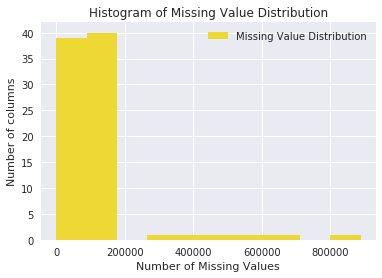

In [95]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Capture only NaNs in dataset
df_nans = azdias_nan.isnull().sum()


# Plot a histogram of NaN count
plt.hist(df_nans,
         color='#EDD834',
         label='Missing Value Distribution')

# Set the title and labels
plt.title('Histogram of Missing Value Distribution')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of columns')
plt.legend(loc='upper right')

plt.show()

In [96]:
# Investigate patterns in the amount of missing data in each column.

print(df_nans.describe())

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64


In [97]:
# Investigate patterns in the amount of missing data in each column.
# Not really useful at this point as there are too many features to make the graph interpretable
#sns.heatmap(azdias_nan.isnull(), cbar=False)

In [98]:
# Investigate patterns in the amount of missing data in each column.
# Not really useful at this point as there are too many features to make the graph interpretable
#msno.matrix(azdias_nan)

In [99]:
# Investigate patterns in the amount of missing data in each column.

# Find the names of the columns with more than 200,000 missing observations

outlier_columns = azdias_nan.loc[:, azdias_nan.isnull().sum() > 200000].columns
print(outlier_columns)

# Print the column names and the number of NaNs found in each
for i in range(azdias_nan.shape[1]):
    if azdias_nan.iloc[:, i].isnull().sum() > 200000:
        print(azdias_nan.columns[i], azdias_nan.iloc[:, i].isnull().sum())


Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')
AGER_TYP 685843
GEBURTSJAHR 392318
TITEL_KZ 889061
ALTER_HH 310267
KK_KUNDENTYP 584612
KBA05_BAUMAX 476524


In [100]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#azdias_nan.drop(list_outliers, axis=1, inplace=True)
azdias_nan.drop(outlier_columns, axis=1, inplace=True)
azdias_nan.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

**Dataset Overview**

The Udacity_AZDIAS_Subset dataset consists of 891,211 observations across 85 variables. The variables are broken down as follows; 7 are of the type numeric, 7 consist of mixed values, 1 is classed as interval and the remaining 70 are categorical, 49 of these being ordinal columns. As the majority of columns are categorical or ordinal from the outset the dataset format is generally well suited to a clustering application, granted there will be a number of transformations expected.

**The numerical variables are as follows:**

- GEBURTSJAHR: Year of birth (Includes dates and hence caution needed for recoding)
- ANZ_PERSONEN: Noumber of adults in household
- ANZ_TITEL: Number of professional title holders in household
- ANZ_HAUSHALTE_AKTIV: Number of households in building
- ANZ_HH_TITEL: Number of professional title holders in building
- MIN_GEBAEUDEJAHR: First year building was recorded in the database (Includes dates and hence caution needed for recoding)
- KBA13_ANZAHL_PKW: Number of cars in the PLZ8 region

**Missing data**

The total amount of missing data present in the dataset is approx. 11%. From looking at a histogram of the data for the NaN values, the vast majority of variables (approximately 92%) have less than 200,000 NaN entries. Therefore, I have considered outliers as variables with more than 200,000 NaN entries. Since there is a large fraction of variables remaining after removing outliers (79/85), and due to the fraction of missing values in the designated outliers being high, it is unlikely that too much significant information will be lost when removing these variables.

An overall assessment of the dataset shows that there is approximately 11% of missing values over the 85 columns recorded. Upon further investigation we can see that the average number of missing values throughout the dataset is 98,516 observations of a possible 891,221. This doesn’t provide us with much value yet however as we need to understand where the missing values most frequently occur.

The histogram of missing value frequency distribution shows that there are a handful of columns that have a lot more missing values than the majority of the dataset. Taking anything above the 75% percentile we can identify these columns that do not provide much benefit to the analysis. To be more precise, taking any columns with greater than 200,000 missing values returns the following:
- AGER_TYP 685843 Best-ager typology
- GEBURTSJAHR 392318 Year of birth
- TITEL_KZ 889061 Academic title flag
- ALTER_HH 310267 Birthdate of head of household
- KK_KUNDENTYP 584612 Consumer pattern over past 12 months
- KBA05_BAUMAX 476524 Most common building type within the microcell
These columns were subsequently removed from the dataset as they have an insufficient amount of data to be used in the analysis. These leaves a total of 79 features remaining at this point, still plenty.

**Patterns in missing data**

There does not appear to be any relationship between the number of missing values in the outlier columns, however if I were to guess why these columns are so sparse it may be that certain people do not feel comfortable providing information about their age, some of the population may not hold or know their academic title and it is unlikely that the majority of people record their consumer pattern with any rigor.
There are some minor patterns in missing values for variables that are inter-related or dependent. For example, if a value is missing in a variable related to an address than it is likely not all fields will be relevant for certain types of housing or geographic locations. (BALLRAUM, EWDICHTE, and INNENSTADT).
Thankfully, there are several columns that do not contain any missing values, which I assume were mandatory fields when designing the data collection method (survey or otherwise).
These include:
'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'

Most of these variables represent two key groups of information; financial typology and personality typology which you could argue are quite fundamental to understanding your customers behaviour and price range.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [101]:
# How much data is missing in each row of the dataset?

print(azdias_nan.isnull().sum(axis=1).describe())
print(azdias_nan.isnull().std(axis=1))

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64
0         0.501216
1         0.000000
2         0.000000
3         0.285992
4         0.000000
5         0.000000
6         0.000000
7         0.000000
8         0.000000
9         0.000000
10        0.000000
11        0.494041
12        0.266610
13        0.303608
14        0.494041
15        0.303608
16        0.266610
17        0.494041
18        0.192356
19        0.000000
20        0.334629
21        0.000000
22        0.000000
23        0.303608
24        0.494041
25        0.245042
26        0.430122
27        0.000000
28        0.000000
29        0.158088
            ...   
891191    0.000000
891192    0.000000
891193    0.000000
891194    0.000000
891195    0.000000
891196    0.000000
891197    0.000000
891198    0.000000
891199    0.000000
891200    0.000000
891201    0.000000
891

In [102]:
# How much data is missing in each row of the dataset?

#msno.dendrogram(azdias_nan)

In [103]:
# How much data is missing in each row of the dataset?

#msno.heatmap(azdias_nan)

In [104]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

def subset_on_rows(df, q):
    '''
    Splits dataframe into two subsets. Dataframe is split on the 
    desired quantile for missing NaNs.
    
    INPUT: dataframe, quantile of missing NaNs
    OUTPUT: 2 x dataframe - one above and one below quantile threshold chosen
    '''
    
    row_split = df.isnull().sum(axis=1).quantile([q]).tolist()
    
    above_split = df[df.isnull().sum(axis=1) > row_split].copy()
    below_split = df[df.isnull().sum(axis=1) <= row_split].copy()
    
    return above_split, below_split

azdias_above_split, azdias_below_split = subset_on_rows(azdias, 0.75)

print(f"No. rows in subset below 75% Quantile NaNs: {azdias_below_split.shape[0]}")
print(f"No. rows in subset above 75% Quantile NaNs: {azdias_above_split.shape[0]}")
print(type(azdias_below_split))

No. rows in subset below 75% Quantile NaNs: 684502
No. rows in subset above 75% Quantile NaNs: 206719
<class 'pandas.core.frame.DataFrame'>


In [105]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#azdias_above_split.head(10) 
#azdias_below_split.head(10)

# Strip out columns with no NaNs
azdias_above_split_cols = azdias_above_split.loc[:, azdias_above_split.isnull().sum() == 0].columns
azdias_below_split_cols = azdias_below_split.loc[:, azdias_below_split.isnull().sum() == 0].columns

# Find column intersections between dataframes
print(f"Columns above 75% Quantile Cut Off: {azdias_above_split_cols}")
print(f"Columns below 75% Quantile Cut Off: {azdias_below_split_cols}")
print(f"Columns intersection: {azdias_above_split_cols & azdias_below_split_cols}")
intersection_columns = azdias_above_split_cols & azdias_below_split_cols
#Index([u'B', u'C'], dtype='object')

# msno.matrix(df)
# msno.heatmap(df)

Columns above 75% Quantile Cut Off: Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')
Columns below 75% Quantile Cut Off: Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'S

In [106]:
# Checking for similarities in outlier row distributions

def comparison_plot(columns):
    '''
    Takes in categorical variable intersection between both
    dataframes and compares the distribution of values 
    in each
    
    INPUT: List of some intersection columns
    OUTPUT: Countplot frequency graphs of chosen columns
    '''
    
    num_rows = len(columns)
    
    fig, ax = plt.subplots(figsize=(20, 25), ncols= 2, nrows= num_rows, squeeze=False)
    
    ax[0][0].set_title("Above Cut off Quantile")
    ax[0][1].set_title("Below Cut off Quantile")
    sns.set(style="darkgrid")
    
    for i in range(num_rows):
        sns.countplot(x=columns[i], data= azdias_above_split,ax=ax[i][0])
        sns.countplot(x=columns[i], data= azdias_below_split,ax=ax[i][1])
        
        

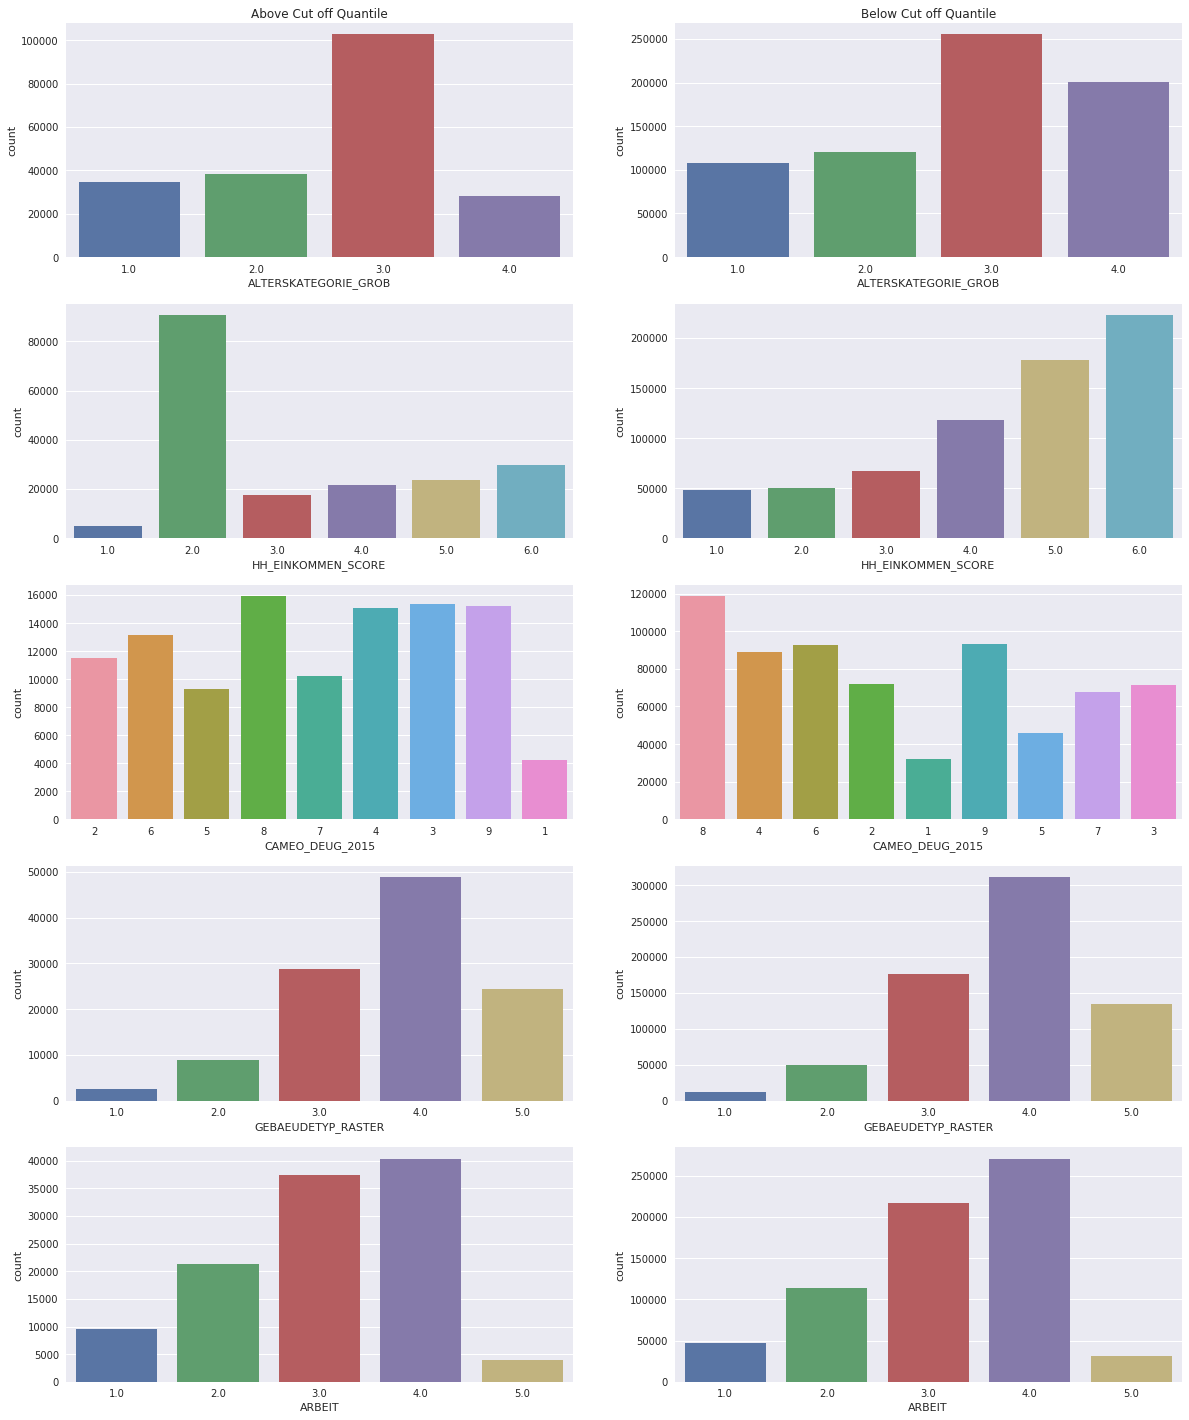

In [107]:
# Checking for similarities in row distributions using 5 columns deemed important prior to PCA

comparison_plot(["ALTERSKATEGORIE_GROB", "HH_EINKOMMEN_SCORE", "CAMEO_DEUG_2015", "GEBAEUDETYP_RASTER", "ARBEIT"])

# ### 1.2. ALTERSKATEGORIE_GROB
# Estimated age based on given name analysis
# - -1: unknown (missing)
# -  0: unknown (cannot be determined)
# -  1: < 30 years old
# -  2: 30 - 45 years old
# -  3: 46 - 60 years old
# -  4: > 60 years old
# -  9: uniformly distributed
    
# ### 2.4. HH_EINKOMMEN_SCORE
# Estimated household net income
# - -1: unknown
# -  0: unknown
# -  1: highest income
# -  2: very high income
# -  3: high income
# -  4: average income
# -  5: lower income
# -  6: very low income

# ### 4.1. CAMEO_DEUG_2015
# German CAMEO: Wealth / Life Stage Typology, rough scale
# - -1: unknown
# -  1: upper class
# -  2: upper middleclass
# -  3: established middleclass
# -  4: consumption-oriented middleclass
# -  5: active middleclass
# -  6: low-consumption middleclass
# -  7: lower middleclass
# -  8: working class
# -  9: urban working class
# -  X: unknown
    
# ### 7.1. GEBAEUDETYP_RASTER
# Ratio of residential to commercial activity
# - 1: business cell
# - 2: mixed cell with high business share
# - 3: mixed cell with middle business share
# - 4: mixed cell with low business share
# - 5: residential cell
    
    
# ### 9.1. ARBEIT
# Share of unemployment in community
# - -1: unknown
# -  1: very low
# -  2: low
# -  3: average
# -  4: high
# -  5: very high
# -  9: unknown

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

**Summary of Data Missing in Each Row**

Looking at a high-level view of the data missing in each row of the dataset we can see the following summary statistics:

Mean 6
Std	13
Min	0
25%	0
50%	0
75%	3
Max	49

This gives us an idea of the distribution of complete rows in the dataset. That fact that the mean number of missing values is 6 and the everything below the 50% quartile suggests that there are some outlier rows that skew the mean.

**Determining the Cut-Off Point**

To further profile this it was decided to use the 75% quartile as the cut off between many missing values and few missing values:
No. rows in subset below 75% Quantile NaNs: 684502
No. rows in subset above 75% Quantile NaNs: 206719
We can see clearly the number of rows with more than 3 missing values is far less than those with less than 3, which is intuitive but a good sign. The next step is to understand if the distribution of missing values in rows is similar across a set of features in the dataset. To do this we will plot the intersection variables between the two subsets created that both contain few missing values.

**Graphical Comparison**

The intersection columns with few missing values were identified as the following:
Columns intersection: 
'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP

From this subset I decided to compare five columns which I deemed to be important prior to conducting PCA in a future step:
ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
HH_EINKOMMEN_SCORE (Estimated household net income)
CAMEO_DEUG_2015 (German CAMEO: Wealth / Life Stage Typology, rough scale)
GEBAEUDETYP_RASTER (Ratio of residential to commercial activity)
ARBEIT (Share of unemployment in community)

From the histograms provided there is evidence that there appears to be clear differences between the relative distributions of the subsets for the features selected. This is most apparent for ALTERSKATEGORIE_GROB, GEBAEUDETYP_RASTER and ARBEIT, whereas HH_EINKOMMEN_SCORE and CAMEO_DEUG_2015 seem to differ in their distributions.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [108]:
# How many features are there of each data type?

feat_info.groupby(by="type").size()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [109]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Capturing categorical variables

categorical_variables = []

for i in range(feat_info.shape[0]):
    if feat_info['type'][i] == 'categorical':
        categorical_variables.append(feat_info['attribute'][i])


#df['hID'].nunique()
binary_variables = []
multi_lev_variables = []

for i, j in enumerate(categorical_variables):
    
    if azdias_below_split.columns.isin([categorical_variables[i]]).sum() > 0:
        
        # Investigating multi-level categorical variables
        if len(set(azdias_below_split[categorical_variables[i]].values)) > 2:
            multi_lev_variables.append(categorical_variables[i])
        else:
        
            # Investigating Binary categorical variables
            if len(set(azdias_below_split[categorical_variables[i]].values)) == 2:
                binary_variables.append(categorical_variables[i])
            else:
                continue

print(f"Binary Columns:\n {binary_variables}")
print(f"Multi Level Columns:\n {multi_lev_variables}")
print(f"Categorical Columns:\n {categorical_variables}")

Binary Columns:
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi Level Columns:
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Categorical Columns:
 ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [110]:
# Checking for Columns with only 1 unique value

non_unique_cols = []
for col in azdias_below_split.columns:
    if len(azdias_below_split[col].unique()) == 1:
        non_unique_cols.append(azdias_below_split[col])
print(len(non_unique_cols))

0


In [111]:
# Checking Column consistency of Binary variables

azdias_below_split.loc[0:5, binary_variables]

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2,0,1.0,2.0,W
2,2,1,0.0,1.0,W
4,1,0,0.0,2.0,W
5,2,0,0.0,2.0,W


In [112]:
# Recoding OST_West_KZ to binary numeric values for consistency

azdias_below_split['RECODE_OST_WEST_KZ'] = azdias_below_split['OST_WEST_KZ']
codemap = {'W': 0, 'O': 1}
azdias_below_split = azdias_below_split.replace({'RECODE_OST_WEST_KZ': codemap})

# Checking re-encoding worked
azdias_below_split.loc[190:200,['OST_WEST_KZ', 'RECODE_OST_WEST_KZ']]

,OST_WEST_KZ,RECODE_OST_WEST_KZ
190,W,0
192,W,0
194,W,0
195,W,0
196,W,0
198,O,1
200,O,1


In [113]:
# Drop Original OST_West_KZ column

azdias_below_split.drop(['OST_WEST_KZ'], axis=1, inplace=True)
azdias_below_split.shape

(684502, 79)

In [114]:
# Checking Column consistency of Multi Level variables

azdias_below_split.loc[0:5, multi_lev_variables]

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,5.0,1,10.0,5.0,3.0,2.0,1.0,1.0,3.0,5,8.0,8,8A
2,3.0,1,10.0,1.0,1.0,3.0,2.0,1.0,2.0,5,1.0,4,4C
4,5.0,5,5.0,10.0,5.0,3.0,2.0,1.0,2.0,4,1.0,6,6B
5,2.0,2,1.0,1.0,1.0,4.0,2.0,1.0,0.0,4,1.0,8,8C


In [115]:
# One-hot-encoding multi-level categorical variables to maintain them for analysis

# Converting possible numeric levels to strings for encoding
multi_level_cats = pd.DataFrame(azdias_below_split[multi_lev_variables], columns = multi_lev_variables).astype(str)

# Finding NaNs that were converted to strings
(multi_level_cats == 'nan').sum()

CJT_GESAMTTYP          0
FINANZTYP              0
GFK_URLAUBERTYP        0
LP_FAMILIE_FEIN        0
LP_FAMILIE_GROB        0
LP_STATUS_FEIN         0
LP_STATUS_GROB         0
NATIONALITAET_KZ       0
SHOPPER_TYP            0
ZABEOTYP               0
GEBAEUDETYP            0
CAMEO_DEUG_2015     2639
CAMEO_DEU_2015      2639
dtype: int64

In [116]:
# Creating true null values
multi_level_cats['CAMEO_DEUG_2015'] = multi_level_cats['CAMEO_DEUG_2015'].replace('nan', np.nan)
multi_level_cats['CAMEO_DEU_2015'] = multi_level_cats['CAMEO_DEU_2015'].replace('nan', np.nan)

# One-hot encoding
multi_level_cats_encoded = pd.get_dummies(multi_level_cats)
print(f"Encoded Dataset shape: {multi_level_cats_encoded.shape}")

# Dropping original multi-level categorical variables
azdias_below_split.drop(multi_lev_variables, axis=1, inplace=True)
print(f"Originals Dropped Dataset shape: {azdias_below_split.shape}")

# Adding encoded multi-level variables to dataframe
azdias_below_split_1he = pd.concat([azdias_below_split,multi_level_cats_encoded], axis=1)
print(f"Final One Hot Encoded Dataset: {azdias_below_split_1he.shape}")

Encoded Dataset shape: (684502, 128)
Originals Dropped Dataset shape: (684502, 66)
Final One Hot Encoded Dataset: (684502, 194)


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Feature Type Breakdown**

The following table from before presents the datatype breakdown for the 85 features. 
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
These variables need to be investigated further to ensure they are encoded in their correct format. On first inspect the breakdown of binary, multi-level and true categorical is as follows:

Binary Columns (5):
'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'

Multi Level Columns (13):
 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'

Categorical Columns (21):
 'AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'

**Recoding Steps**

-	Of the binary variables identified OST_WEST_KZ included non-numeric values and hence had to be recoded to (0,1). The original OST_WEST_KZ was subsequently dropped.
-	It was identified that for some of the multi-level categorical variables the missing values had not properly been recorded. These values were substituted with true NaN values for CAMEO_DEUG_2015 and CAMEO_DEU_2015. The two original variables were subsequently dropped.
-	All multi-level categorical variables were then one-hot encoded to allow for proper representation and formatting requirements for both PCA and Clustering in future steps. The original multi-level categorical variables were subsequently dropped.

**Final Comparison**

Comparing our original dataset and our recoded dataset we note the following changes:
Encoded Dataset shape: (684502, 128)
Originals Dropped Dataset shape: (684502, 66)
Final One Hot Encoded Dataset: (684502, 194)


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [117]:
# Capturing mixed variables that require attention

mixed_names = []

for i in range(feat_info.shape[0]):
    if feat_info['type'][i] == 'mixed':
        mixed_names.append(feat_info['attribute'][i])

print(f"Mixed type variables:\n{mixed_names}\n")
azdias_below_split.loc[0:5, mixed_names]

Mixed type variables:
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']



/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,KBA05_BAUMAX,PLZ8_BAUMAX
1,21.0,6.0,14.0,4.0,51,NaN,1.0
2,3.0,1.0,15.0,2.0,24,NaN,1.0
4,32.0,10.0,8.0,3.0,43,NaN,2.0
5,8.0,2.0,3.0,7.0,54,NaN,1.0


In [118]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# As taken from the Data Dictionary

### 1.18. PRAEGENDE_JUGENDJAHRE
# Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
# - -1: unknown
# -  0: unknown
# -  1: 40s - war years (Mainstream, E+W)
# -  2: 40s - reconstruction years (Avantgarde, E+W)
# -  3: 50s - economic miracle (Mainstream, E+W)
# -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
# -  5: 60s - economic miracle (Mainstream, E+W)
# -  6: 60s - generation 68 / student protestors (Avantgarde, W)
# -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
# -  8: 70s - family orientation (Mainstream, E+W)
# -  9: 70s - peace movement (Avantgarde, E+W)
# - 10: 80s - Generation Golf (Mainstream, W)
# - 11: 80s - ecological awareness (Avantgarde, W)
# - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
# - 13: 80s - Swords into ploughshares (Avantgarde, E)
# - 14: 90s - digital media kids (Mainstream, E+W)
# - 15: 90s - ecological awareness (Avantgarde, E+W)


# Creating variable to capture time period of generation
time_period_dic = {1: 1.0, 2: 1.0, 3: 2.0, 4: 2.0, 5: 3.0,\
                6: 3.0, 7: 3.0, 8: 4.0, 9: 4.0, 10: 5.0,\
                11: 5.0, 12: 5.0, 13: 5.0, 14: 6.0, 15: 6.0}

azdias_below_split_1he["PJ_Period"] = azdias_below_split_1he["PRAEGENDE_JUGENDJAHRE"]
azdias_below_split_1he["PJ_Period"] = azdias_below_split_1he["PJ_Period"].map(time_period_dic)

# Creating variable to capture Movement type
movement_dic = {1: 1.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 1.0, 6: 0.0,\
                 7: 0.0, 8: 1.0, 9: 0.0, 10: 1.0, 11: 0.0, 12: 1.0,\
                 13: 0.0, 14: 1.0, 15: 0.0}

azdias_below_split_1he["PJ_Movement"] = azdias_below_split_1he["PRAEGENDE_JUGENDJAHRE"]
azdias_below_split_1he["PJ_Movement"] = azdias_below_split_1he["PJ_Movement"].map(movement_dic)


# Dropping original PRAEGENDE_JUGENDJAHRE column from dataframe
azdias_below_split_1he.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1, inplace=True)
azdias_below_split_1he.shape


(684502, 195)

In [119]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

### 4.3. CAMEO_INTL_2015
# German CAMEO: Wealth / Life Stage Typology, mapped to international code
# - -1: unknown
# - 11: Wealthy Households - Pre-Family Couples & Singles
# - 12: Wealthy Households - Young Couples With Children
# - 13: Wealthy Households - Families With School Age Children
# - 14: Wealthy Households - Older Families &  Mature Couples
# - 15: Wealthy Households - Elders In Retirement
# - 21: Prosperous Households - Pre-Family Couples & Singles
# - 22: Prosperous Households - Young Couples With Children
# - 23: Prosperous Households - Families With School Age Children
# - 24: Prosperous Households - Older Families & Mature Couples
# - 25: Prosperous Households - Elders In Retirement
# - 31: Comfortable Households - Pre-Family Couples & Singles
# - 32: Comfortable Households - Young Couples With Children
# - 33: Comfortable Households - Families With School Age Children
# - 34: Comfortable Households - Older Families & Mature Couples
# - 35: Comfortable Households - Elders In Retirement
# - 41: Less Affluent Households - Pre-Family Couples & Singles
# - 42: Less Affluent Households - Young Couples With Children
# - 43: Less Affluent Households - Families With School Age Children
# - 44: Less Affluent Households - Older Families & Mature Couples
# - 45: Less Affluent Households - Elders In Retirement
# - 51: Poorer Households - Pre-Family Couples & Singles
# - 52: Poorer Households - Young Couples With Children
# - 53: Poorer Households - Families With School Age Children
# - 54: Poorer Households - Older Families & Mature Couples
# - 55: Poorer Households - Elders In Retirement
# - XX: unknown

# Creating new variable to capture wealth indicator

wealth_dic = {'11': 1.0, '12': 1.0, '13': 1.0, '14': 1.0, '15': 1.0,\
                      '21': 2.0, '22': 2.0, '23': 2.0, '24': 2.0, '25': 2.0,\
                      '31': 3.0, '32': 3.0, '33': 3.0, '34': 3.0, '35': 3.0,\
                      '41': 4.0, '42': 4.0, '43': 4.0, '44': 4.0, '45': 4.0,\
                      '51': 5.0, '52': 5.0, '53': 5.0, '54': 5.0, '55': 1.0}

azdias_below_split_1he["CI15_Wealth"] = azdias_below_split_1he["CAMEO_INTL_2015"]
azdias_below_split_1he["CI15_Wealth"] = azdias_below_split_1he["CI15_Wealth"].map(wealth_dic)

# Creating new variable to capture life/family type

life_stage_dic = {'11': 1.0, '12': 2.0, '13': 3.0, '14': 4.0, '15': 5.0,\
                  '21': 1.0, '22': 2.0, '23': 3.0, '24': 4.0, '25': 5.0,\
                  '31': 1.0, '32': 2.0, '33': 3.0, '34': 4.0, '35': 5.0,\
                  '41': 1.0, '42': 2.0, '43': 3.0, '44': 4.0, '45': 5.0,\
                  '51': 1.0, '52': 2.0, '53': 3.0, '54': 4.0, '55': 5.0}

azdias_below_split_1he["CI15_LS"] = azdias_below_split_1he["CAMEO_INTL_2015"]
azdias_below_split_1he["CI15_LS"] = azdias_below_split_1he["CI15_LS"].map(life_stage_dic)

# Dropping original CAMEO_INTL_2015 column from dataframe
azdias_below_split_1he.drop(["CAMEO_INTL_2015"], axis=1, inplace=True) 
azdias_below_split_1he.shape

(684502, 196)

In [120]:
# Investigate "WOHNLAGE" and engineer two new variables.

### 3.7. WOHNLAGE
# Neighborhood quality (or rural flag)
# - -1: unknown
# -  0: no score calculated
# -  1: very good neighborhood
# -  2: good neighborhood
# -  3: average neighborhood
# -  4: poor neighborhood
# -  5: very poor neighborhood
# -  7: rural neighborhood
# -  8: new building in rural neighborhood

# Creating ordinal variable for neighborhood values
neighborhood_dict = {1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0,\
                     5: 5.0, 6: 6.0, 7: np.nan, 8: np.nan}

azdias_below_split_1he["WOHNLAGE_NBH"] = azdias_below_split_1he["WOHNLAGE"]
azdias_below_split_1he["WOHNLAGE_NBH"] = azdias_below_split_1he["WOHNLAGE_NBH"].map(neighborhood_dict)

# Dropping original WOHNLAGE

azdias_below_split_1he.drop(["WOHNLAGE"], axis=1, inplace=True) 
azdias_below_split_1he.shape

(684502, 196)

In [121]:
# Investigate "LP_LEBENSPHASE_GROB" and engineer two new variables.

### 1.12. LP_LEBENSPHASE_GROB
# Life stage, rough scale
# -  1: single low-income and average earners of younger age
# -  2: single low-income and average earners of higher age
# -  3: single high-income earners
# -  4: single low-income and average-earner couples
# -  5: single high-income earner couples
# -  6: single parents
# -  7: single low-income and average earner families
# -  8: high-income earner families
# -  9: average earners of younger age from multiperson households
# - 10: low-income and average earners of higher age from multiperson households
# - 11: high-income earners of younger age from multiperson households
# - 12: high-income earners of higher age from multiperson households

# Dropping non-encoded variables
azdias_below_split_1he.drop(["LP_LEBENSPHASE_FEIN"], axis=1, inplace=True) 
azdias_below_split_1he.shape

azdias_below_split_1he.drop(["LP_LEBENSPHASE_GROB"], axis=1, inplace=True) 
azdias_below_split_1he.shape

(684502, 194)

In [122]:
# Investigate "KBA05_BAUMAX" and engineer two new variables.

### 5.5. KBA05_BAUMAX
# Most common building type within the microcell
# - -1: unknown
# -  0: unknown
# -  1: mainly 1-2 family homes in the microcell
# -  2: mainly 3-5 family homes in the microcell
# -  3: mainly 6-10 family homes in the microcell
# -  4: mainly 10+ family homes in the microcell
# -  5: mainly business buildings in the microcell

# Has been dropped already due to number of NaNs


In [123]:
# Investigate "PLZ8_BAUMAX" and engineer two new variables.

### 8.6. PLZ8_BAUMAX
# Most common building type within the PLZ8 region
# - -1: unknown
# -  0: unknown
# -  1: mainly 1-2 family homes
# -  2: mainly 3-5 family homes
# -  3: mainly 6-10 family homes
# -  4: mainly 10+ family homes
# -  5: mainly business buildings

# Ordinal variable for no. of homes
homes_dict = {1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0}

azdias_below_split_1he["PLZ8_BAUMAX_HOMES"] = azdias_below_split_1he["PLZ8_BAUMAX"]
azdias_below_split_1he["PLZ8_BAUMAX_HOMES"] = azdias_below_split_1he["PLZ8_BAUMAX_HOMES"].map(homes_dict)

# Binary categorical variable for business buildings
business_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 1}

azdias_below_split_1he["PLZ8_BAUMAX_BUSINESS"] = azdias_below_split_1he["PLZ8_BAUMAX"]
azdias_below_split_1he["PLZ8_BAUMAX_BUSINESS"] = azdias_below_split_1he["PLZ8_BAUMAX_BUSINESS"].map(business_dict)

# Dropping original variable
azdias_below_split_1he.drop(["PLZ8_BAUMAX"], axis=1, inplace=True) 
azdias_below_split_1he.shape

(684502, 195)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**Mixed Variable Types Initial Comments**
Other than the two variables that were called out in the guidelines (PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015) it is important to be thorough with the cleaning process, particularly if such code is required to become functional later. It also ensures we preserve any potentially valuable information by formatting the data properly.
The first step was to identify which variables required attention by investigating the mixed type variables and then translating them to understand why data may have been recorded in such a way and what was the best way to rectify the levels observed in each feature. The following mixed variables were collected for recoding:
-	PRAEGENDE_JUGENDJAHRE (Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west))
-	CAMEO_INTL_2015 (German CAMEO: Wealth / Life Stage Typology, mapped to international code)
-	WOHNLAGE (Neighborhood quality (or rural flag))
-	LP_LEBENSPHASE_GROB (Life stage, rough scale)
-	KBA05_BAUMAX (Most common building type within the microcell)
-	PLZ8_BAUMAX (Most common building type within the PLZ8 region)
-	LP_LEBENSPHASE_FEIN (Life stage, fine scale)

**PRAEGENDE_JUGENDJAHRE**

As instructed, I created two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement. The original column was deleted from the dataset.

**CAMEO_INTL_2015**

As instructed, I broke up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables, one for wealth and one for life stage (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values). 

**WOHNLAGE**

For this variable I created an ordinal dictionary to map the neighbourhood quality. I also removed the values for rural neighbourhoods as they do not fit with the consistency of neighbourhood quality, rather they are a classification of neighbourhood type. The original column was deleted from the dataset.


**LP_LEBENSPHASE_GROB**

On closer look LP_LEBENSPHASE_GROB is just a less detailed version of LP_LEBENSPHASE_FEIN and hence before deciding on what to do with LP_LEBENSPHASE_FEIN I decided to remove LP_LEBENSPHASE_GROB as they cover the same information.

**KBA05_BAUMAX**

This feature had previously been excluded from the dataset due to the large number of missing values found.

**PLZ8_BAUMAX**

The variable was split into two separate features to capture the family home levels and business level respectively. The first of these was an ordinal variable to capture the size of the family home. The second of these was a binary variable created to capture whether or not the building was for commercial purposes. The original column was deleted from the dataset.

**LP_LEBENSPHASE_FEIN**

LP_LEBENSPHASE_FEIN looks to have been created from levels of other variables within the dataset. As a result, I suspect this feature will not add much further information that would prove relevant in both PCA and Clustering. Hence, I decided to drop this column.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [124]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Print final columns in dataframe

print(azdias_below_split_1he.columns)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'PJ_Period', 'PJ_Movement', 'CI15_Wealth', 'CI15_LS', 'WOHNLAGE_NBH',
       'PLZ8_BAUMAX_HOMES', 'PLZ8_BAUMAX_BUSINESS'],
      dtype='object', length=195)


In [125]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#print df.isnull().values.any()

# Follow this syntax
#np.where(if_this_condition_is_true, do_this, else_this)
# Example
#df['new_column'] = np.where(df[i] > 10, 'foo', 'bar) 

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [126]:
def clean_data(train_df, test_dataset, feat_info, cut_off_q):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    
    # Put in code here to execute all main cleaning steps:
    
    
    # Useful lists
    outliers = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    
    multi_lvl_cols = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', \
                      'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', \
                      'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    
    # Adding these to drop list as they are removed during recoding anyway
    drop_list = outliers + ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']
    
    
    
    # Step 1: convert missing value codes into NaNs, ...
    
   # Parse and map missing codes to columns
      
    for i in range(len(test_dataset.columns)):
        if feat_info['m_o_u_decoded'][i] != []:
            test_dataset.iloc[:, i] = test_dataset.iloc[:, i].replace(feat_info['m_o_u_decoded'][i], np.nan)
        else:
            continue
    
    
    # Step 2: remove selected columns and rows, ...
    
    #test_dataset.columns(drop_list, axis=1, inplace=True)
        
    for i,j in enumerate(drop_list):
        if j in list(test_dataset.columns):
            test_dataset.drop(j, axis=1, inplace=True)
        else:
            continue
            
            
    # Step 3: select, re-encode, and engineer column values.        
    
    # Ensuring consistency across multi level columns identified in new dataframe
    
    multi_lvl_vars_updated = []        
    for i,j in enumerate(multi_lev_variables):
        if multi_lev_variables[i] in list(test_dataset.columns):
            multi_lvl_vars_updated.append(j)
        else:
            continue
    

    # Creating row data subsets
    
    row_split = test_dataset.isnull().sum(axis=1).quantile([cut_off_q]).tolist()
    
    df_above_split = test_dataset[test_dataset.isnull().sum(axis=1) > row_split].copy()
    df_below_split = test_dataset[test_dataset.isnull().sum(axis=1) <= row_split].copy()
    
    # Step 3.1 - Categorical variables 
    
    # Recoding OST_West_KZ to binary numeric values for consistency

    df_below_split['RECODE_OST_WEST_KZ'] = df_below_split['OST_WEST_KZ']
    codemap = {'W': 0, 'O': 1}
    df_below_split = df_below_split.replace({'RECODE_OST_WEST_KZ': codemap})
    df_below_split.drop(['OST_WEST_KZ'], axis=1, inplace=True)
    
    
    # One-hot-encoding multi-level categorical variables to maintain them for analysis

    # Converting possible numeric levels to strings for encoding
    multi_level_cats = pd.DataFrame(df_below_split[multi_lvl_vars_updated], columns = multi_lvl_vars_updated).astype(str)

    # Creating true null values
    multi_level_cats[multi_lvl_vars_updated] = multi_level_cats[multi_lvl_vars_updated].replace('nan', np.nan)
    
    # One-hot encoding
    multi_level_cats_encoded = pd.get_dummies(multi_level_cats)

    # Dropping original multi-level categorical variables
    df_below_split.drop(multi_lvl_vars_updated, axis=1, inplace=True)

    # Adding encoded multi-level variables to dataframe
    df_below_split_1he = pd.concat([df_below_split,multi_level_cats_encoded], axis=1)

    
    # Step 3.2 - Mixed variables recoding
    
    ### 1.18. PRAEGENDE_JUGENDJAHRE
    # Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
    
    # Creating variable to capture time period of generation
    time_period_dic = {1: 1.0, 2: 1.0, 3: 2.0, 4: 2.0, 5: 3.0,\
                6: 3.0, 7: 3.0, 8: 4.0, 9: 4.0, 10: 5.0,\
                11: 5.0, 12: 5.0, 13: 5.0, 14: 6.0, 15: 6.0}

    df_below_split_1he["PJ_Period"] = df_below_split_1he["PRAEGENDE_JUGENDJAHRE"]
    df_below_split_1he["PJ_Period"] = df_below_split_1he["PJ_Period"].map(time_period_dic)

    # Creating variable to capture Movement type
    movement_dic = {1: 1.0, 2: 0.0, 3: 1.0, 4: 0.0, 5: 1.0, 6: 0.0,\
                 7: 0.0, 8: 1.0, 9: 0.0, 10: 1.0, 11: 0.0, 12: 1.0,\
                 13: 0.0, 14: 1.0, 15: 0.0}

    df_below_split_1he["PJ_Movement"] = df_below_split_1he["PRAEGENDE_JUGENDJAHRE"]
    df_below_split_1he["PJ_Movement"] = df_below_split_1he["PJ_Movement"].map(movement_dic)


    # Dropping original PRAEGENDE_JUGENDJAHRE column from dataframe
    df_below_split_1he.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1, inplace=True)
    
    
    ### 4.3. CAMEO_INTL_2015
    # German CAMEO: Wealth / Life Stage Typology, mapped to international code
    
    # Creating new variable to capture wealth indicator

    wealth_dic = {'11': 1.0, '12': 1.0, '13': 1.0, '14': 1.0, '15': 1.0,\
                      '21': 2.0, '22': 2.0, '23': 2.0, '24': 2.0, '25': 2.0,\
                      '31': 3.0, '32': 3.0, '33': 3.0, '34': 3.0, '35': 3.0,\
                      '41': 4.0, '42': 4.0, '43': 4.0, '44': 4.0, '45': 4.0,\
                      '51': 5.0, '52': 5.0, '53': 5.0, '54': 5.0, '55': 1.0}

    df_below_split_1he["CI15_Wealth"] = df_below_split_1he["CAMEO_INTL_2015"]
    df_below_split_1he["CI15_Wealth"] = df_below_split_1he["CI15_Wealth"].map(wealth_dic)

    # Creating new variable to capture life/family type

    life_stage_dic = {'11': 1.0, '12': 2.0, '13': 3.0, '14': 4.0, '15': 5.0,\
                  '21': 1.0, '22': 2.0, '23': 3.0, '24': 4.0, '25': 5.0,\
                  '31': 1.0, '32': 2.0, '33': 3.0, '34': 4.0, '35': 5.0,\
                  '41': 1.0, '42': 2.0, '43': 3.0, '44': 4.0, '45': 5.0,\
                  '51': 1.0, '52': 2.0, '53': 3.0, '54': 4.0, '55': 5.0}

    df_below_split_1he["CI15_LS"] = df_below_split_1he["CAMEO_INTL_2015"]
    df_below_split_1he["CI15_LS"] = df_below_split_1he["CI15_LS"].map(life_stage_dic)

    # Dropping original CAMEO_INTL_2015 column from dataframe
    df_below_split_1he.drop(["CAMEO_INTL_2015"], axis=1, inplace=True) 
    df_below_split_1he.shape

    
    # Investigate "WOHNLAGE" and engineer two new variables.

    ### 3.7. WOHNLAGE
    # Neighborhood quality (or rural flag)

    # Creating ordinal variable for neighborhood values
    neighborhood_dict = {1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0,\
                     5: 5.0, 6: 6.0, 7: np.nan, 8: np.nan}

    df_below_split_1he["WOHNLAGE_NBH"] = df_below_split_1he["WOHNLAGE"]
    df_below_split_1he["WOHNLAGE_NBH"] = df_below_split_1he["WOHNLAGE_NBH"].map(neighborhood_dict)

    # Dropping original WOHNLAGE

    df_below_split_1he.drop(["WOHNLAGE"], axis=1, inplace=True) 
    
    
    
    # Investigate "PLZ8_BAUMAX" and engineer two new variables.

    ### 8.6. PLZ8_BAUMAX
    # Most common building type within the PLZ8 region

    # Ordinal variable for no. of homes
    homes_dict = {1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0}

    df_below_split_1he["PLZ8_BAUMAX_HOMES"] = df_below_split_1he["PLZ8_BAUMAX"]
    df_below_split_1he["PLZ8_BAUMAX_HOMES"] = df_below_split_1he["PLZ8_BAUMAX_HOMES"].map(homes_dict)

    # Binary categorical variable for business buildings
    business_dict = {1: 0, 2: 0, 3: 0, 4: 0, 5: 1}

    df_below_split_1he["PLZ8_BAUMAX_BUSINESS"] = df_below_split_1he["PLZ8_BAUMAX"]
    df_below_split_1he["PLZ8_BAUMAX_BUSINESS"] = df_below_split_1he["PLZ8_BAUMAX_BUSINESS"].map(business_dict)

    # Dropping original variable
    df_below_split_1he.drop(["PLZ8_BAUMAX"], axis=1, inplace=True) 
    
    
    # Check for column consistency between
    # population data and customer data
    
    population_vars = list(train_df.columns)
    customer_vars = list(df_below_split_1he.columns)

    for i in population_vars:
        if i not in customer_vars:
            df_below_split_1he[i] = 0
    
    
    # Checking to see how many NaNs still exist in the data

    if df_below_split_1he.isnull().values.any():
        df_below_split_1he.fillna(0, inplace=True)
    else:
        print("All clean")

    print(f"No. of rows containing any NaNs:{ (df_below_split_1he.isnull().sum(axis=1) > 0).sum() }")

    print(f"Total no. of NaNs: { df_below_split_1he.isnull().sum().sum() }")    

    # Create a copy in which to replace NaNs for Scaler
    df_cleaned = df_below_split_1he
    
    print(f"No. of rows remaining:{ df_cleaned.shape[0] }")
    print(f"No. of cols remaining:{ df_cleaned.shape[1] }")
    
    # Return the cleaned dataframe.
    return df_cleaned

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [127]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Ensure to change reference to output of cleaning function
# First run used initial dataframe and then returned to complete cleaning function

# Checking to see how many NaNs still exist in the data

if azdias_below_split_1he.isnull().values.any():
    azdias_below_split_1he.fillna(0, inplace=True)
else:
    print("All clean")

print(f"No. of rows containing any NaNs:{ (azdias_below_split_1he.isnull().sum(axis=1) > 0).sum() }")

print(f"Total no. of NaNs: { azdias_below_split_1he.isnull().sum().sum() }")    

# Create a copy in which to replace NaNs for Scaler
azdias_cleaned = azdias_below_split_1he
print(f"No. of rows remaining:{ azdias_cleaned.shape[0] }")
print(f"No. of cols remaining:{ azdias_cleaned.shape[1] }")

No. of rows containing any NaNs:0
Total no. of NaNs: 0
No. of rows remaining:684502
No. of cols remaining:195


In [128]:
# Apply feature scaling to the general population demographics data.

# Define Scaler as required
scaler = StandardScaler()

# Fit and transform the data
azidas_scaled = scaler.fit_transform(azdias_cleaned)

# Consider applying imputation in intermediary step

# Converting back to dataframe
azidas_scaled_df = pd.DataFrame(azidas_scaled, columns = azdias_cleaned.columns,\
                                                index = azdias_cleaned.index)
# Investigate scaling applied correctly
azidas_scaled_df.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PJ_Period,PJ_Movement,CI15_Wealth,CI15_LS,WOHNLAGE_NBH,PLZ8_BAUMAX_HOMES,PLZ8_BAUMAX_BUSINESS
1,-1.747634,0.975423,-1.523655,1.588878,-1.050212,1.513292,1.048651,1.341142,-0.542999,1.038860,...,-0.17991,-0.193076,-0.084106,1.144216,0.558311,1.242487,-1.247917,0.975518,-0.313880,-0.378929
2,0.193497,0.975423,-1.523655,0.908468,-1.771419,-0.548762,0.320698,1.341142,1.841624,1.038860,...,-0.17991,-0.193076,-0.084106,1.144216,-1.791117,-0.764116,0.752917,-0.253161,-0.313880,-0.378929
4,0.193497,-1.025197,0.677626,0.228057,0.392200,-1.236113,0.320698,-0.834925,-0.542999,1.038860,...,-0.17991,-0.193076,-0.084106,-0.185013,0.558311,0.573619,0.085973,0.361178,0.663149,-0.378929
5,-1.747634,0.975423,-0.056134,-1.132765,1.113406,-0.548762,-0.407255,1.341142,-0.542999,1.038860,...,-0.17991,-0.193076,-0.084106,-1.514241,0.558311,1.242487,0.752917,-1.481840,-0.313880,-0.378929
6,-0.777068,0.975423,-1.523655,1.588878,-1.771419,1.513292,1.048651,-0.109569,-0.542999,-0.285764,...,-0.17991,-0.193076,-0.084106,0.479601,0.558311,-0.764116,-0.580972,1.589857,-0.313880,-0.378929


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

**Preliminary Steps**

Prior to selecting and applying a scaler I decided to remove all missing values from the dataset to ensure the data was entirely clean. Although there was a number of rows removed by doing this, I felt there was still enough data remaining to present accurate and valuable analysis. Given additional time and scope I would suggest exploring the effect of imputation on the dataset in combination with applying the scaler. Additionally, it would have been interesting to see the effect of temporarily removing the missing values for the purpose of the scaler as mentioned in the guidelines.

**Applying the Scaler**

I decided to apply sklearn's StandardScaler (which scales the data to have a mean of 0 and a standard deviation of 1) out of simplicity. However, there are other scaler methods available such as RobustScaler that is supposedly more robust to outliers.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [129]:
# Apply PCA to the data.

# Initialising the PCA function
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components, random_state = 22)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

# Lets try PCA with the number of components equal to approximately 75% of the total features
num_components = 146
azidas_pca, azidas_comps = do_pca(num_components, azidas_scaled_df)


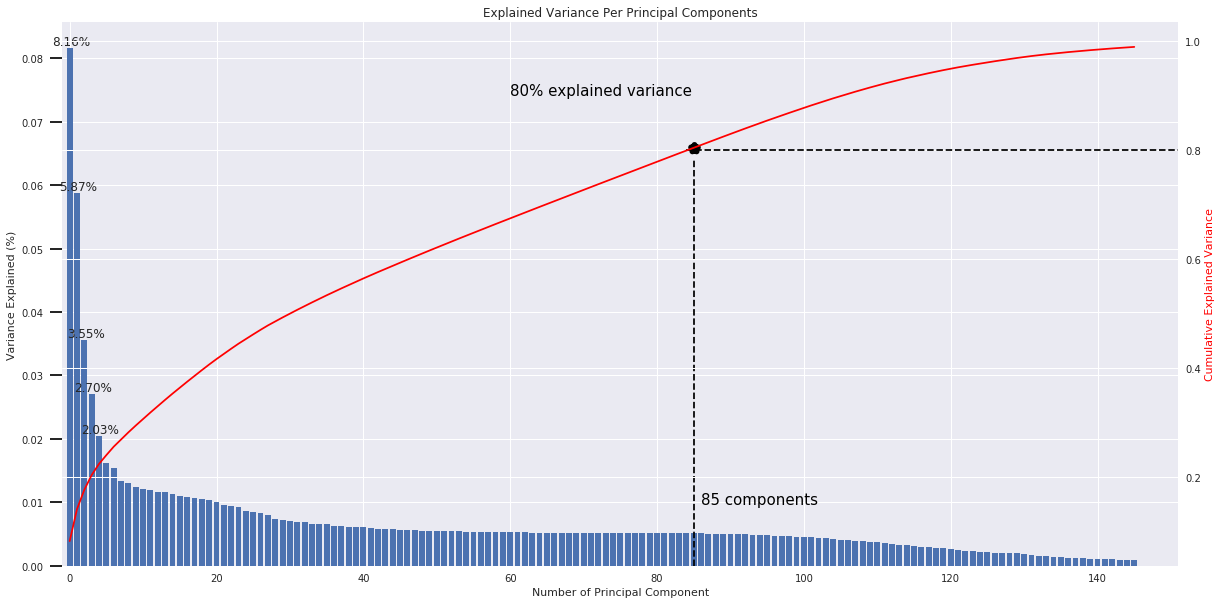

In [130]:
# Investigate the variance accounted for by each principal component.

# Initialising the PCA variance explained plot function
def scree_plot(pca, line_on):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    for i in range(5):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
    #    ax.text(i.get_x()-.1, i+0.002
                
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Number of Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    ax.set_xlim(-1,(num_components+5))
    plt.title('Explained Variance Per Principal Components')
    
    ax2 = ax.twinx()
    ax2.plot(cumvals, color="red")
    if line_on == "Y":
        ax2.hlines(y=0.8,xmin=84,xmax=196,linestyles='dashed')
        ax2.scatter(x = [85], y =[0.803], marker="*", linewidth=6.0, color="black")
        ax2.text(60,0.9,"80% explained variance", fontsize=15, color="black")
        ax2.text(86,0.15,"85 components", fontsize=15, color="black")
        ax.axvline(85, ls="--", color="black", ymax=0.75)
    else:
        ax2.text(86,0.15,"85 components", fontsize=15, color="black")
    
    ax2.set_ylabel('Cumulative Explained Variance', color="red")
    
    optimal_comps = 0
    for index, value in enumerate(cumvals.tolist()): 
        if value >= 0.8:
            optimal_comps = index
            break
        else:
            continue
    return optimal_comps
# Call the function to see how much variance is explained by each principle component
optimal_comps = scree_plot(azidas_pca, "Y")


0

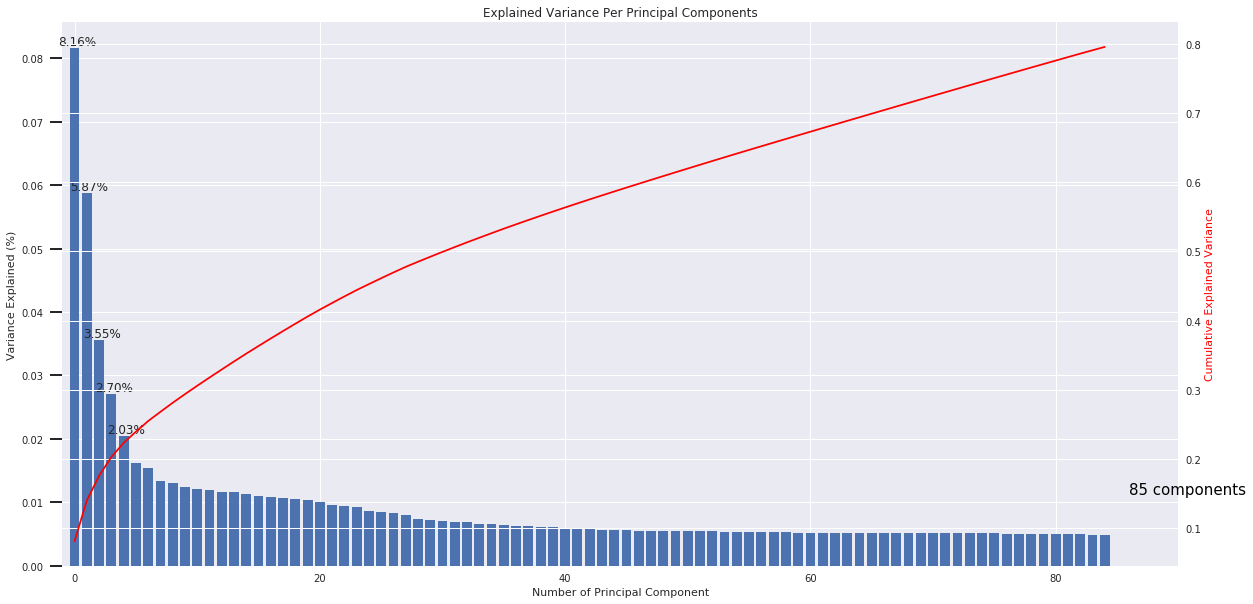

In [131]:
# Re-apply PCA to the data while selecting for number of components to retain.

# Rerun PCA using the optimal number of components
azidas_finalised, comps_finalised = do_pca(optimal_comps, azidas_scaled)

# Plot the results for the optimsied PCA
scree_plot(azidas_finalised, "N")

In [132]:
#print(azidas_finalised)
type(comps_finalised) 

numpy.ndarray

In [133]:
type(azidas_scaled_df)
azidas_scaled_df.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'PJ_Period', 'PJ_Movement', 'CI15_Wealth', 'CI15_LS', 'WOHNLAGE_NBH',
       'PLZ8_BAUMAX_HOMES', 'PLZ8_BAUMAX_BUSINESS'],
      dtype='object', length=195)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

**Deciding on the Optimal number of Components**

When applying PCA it is obvious that there will be a trade-off between computational complexity and cumulative variance explained by the components. Of course, the more components, the higher the explained variance, however that would defeat the purpose of dimensionality reduction and explainability. To counteract this, I decided to select a number of components that met an acceptable level of cumulative variance explained. Looking at the graph that compares the number of components with the cumulative variance explained we can see that between 85 to roughly 95 components explains 80% – 90% of variance respectively

**Final Number of Components**

From the graphical analysis I decided to go with 85 principle components as the optimal number given that they account for approximately 80% of cumulative variance explained. Interestingly the first 6 components explain a cumulative variance of around 23%. After that each additional components additional variance begins to tail off quite linearly. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

,MOBI_REGIO,KBA05_ANTG1,FINANZ_MINIMALIST,PLZ8_ANTG1,KBA05_GBZ,KONSUMNAEHE,PLZ8_GBZ,INNENSTADT,LP_STATUS_GROB_5.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_1.0,WOHNLAGE_NBH,FINANZ_HAUSBAUER,EWDICHTE,ORTSGR_KLS9,CI15_Wealth,PLZ8_ANTG4,HH_EINKOMMEN_SCORE,PLZ8_ANTG3,LP_STATUS_GROB_1.0
Principle Component 1,-0.2031,-0.1896,-0.1864,-0.1817,-0.1806,-0.1341,-0.1332,-0.1265,-0.1128,-0.1128,0.1292,0.1342,0.1403,0.153,0.1539,0.1667,0.1755,0.1804,0.1808,0.1918


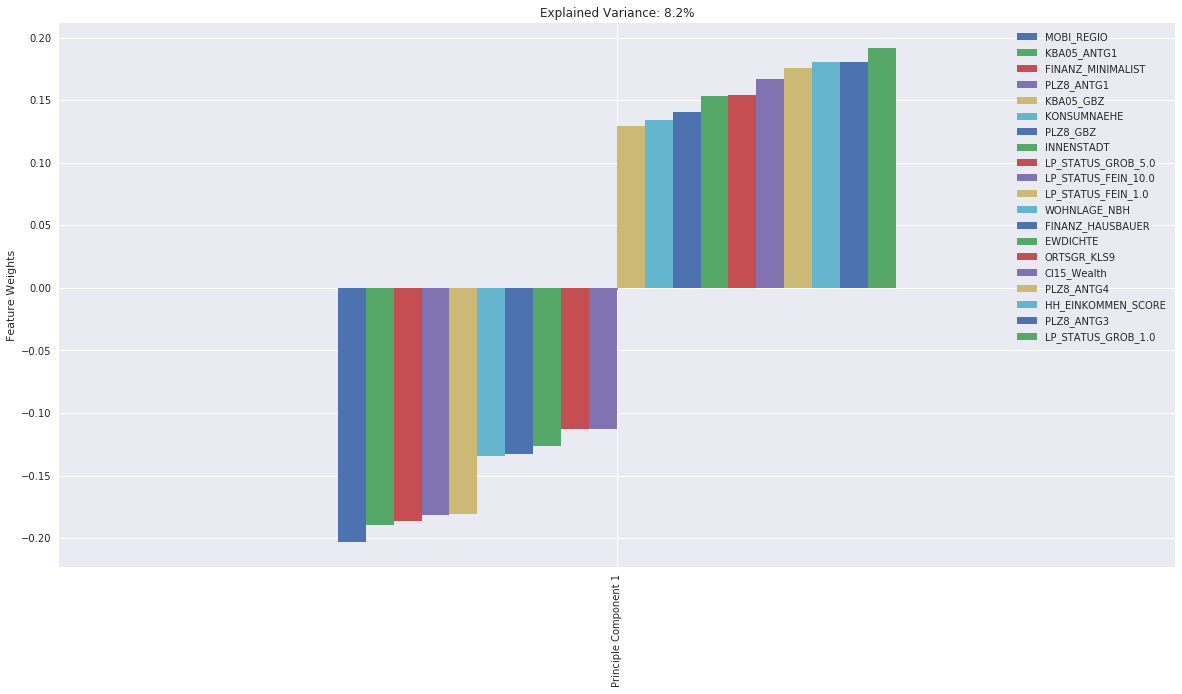

In [134]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_results(scaled_dataset, pca, comp_num):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = [f"Principle Component {i}".format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = scaled_dataset.columns)
	components.index = dimensions
    
	sorted_comps = components.iloc[comp_num-1:comp_num,:].\
                sort_values(f"Principle Component {comp_num}", axis=1, ascending=True,inplace=False, kind='quicksort')

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (20,10))

	# Plot the feature weights as a function of the components
    # Note that this will plot all components and is extremely difficult to read
    # This is overwritten later below for top and bottom 10 but is left as optional
	sorted_comps.plot(ax = ax, kind = 'bar', legend = False);
	ax.set_ylabel("Feature Weights")
	#ax.set_xticklabels(dimensions, rotation=0)
	ax.set_xticklabels(f"Principle Component {comp_num}".format(comp_num))    

	# Display the explained variance ratio
	plt.title(f'Explained Variance: {round(pca.explained_variance_ratio_[comp_num-1]*100,1)}%', fontsize=12)
    
    # Used to capture the top and bottom 10 most important features as full graph is too difficult to interpret
	top_n = sorted_comps.iloc[:,0:10] # Capped at 10 but could be passed as a parameter
	bottom_n = sorted_comps.iloc[:, -10:] # Capped at 10 but could be passed as a parameter
	sorted_top_n = pd.concat([top_n,bottom_n], axis=1)

	# Plot the feature weights as a function of the components
	sorted_top_n.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	#ax.set_xticklabels(dimensions, rotation=0)
	#plt.title(f'Top and Bottom {10} Features', fontsize=12)
    
	# Return a concatenated DataFrame
	#return pd.concat([variance_ratios, components], axis = 1)
	return sorted_top_n

comp_1_results = pca_results(azidas_scaled_df, azidas_finalised, comp_num = 1)
comp_1_results

,PJ_Period,FINANZ_SPARER,SEMIO_REL,FINANZ_UNAUFFAELLIGER,SEMIO_TRADV,SEMIO_PFLICHT,FINANZ_ANLEGER,SEMIO_RAT,SEMIO_KULT,ONLINE_AFFINITAET,FINANZTYP_5,LP_STATUS_FEIN_1.0,CJT_GESAMTTYP_2.0,W_KEIT_KIND_HH,RETOURTYP_BK_S,SEMIO_LUST,SEMIO_ERL,ZABEOTYP_3,FINANZ_VORSORGER,ALTERSKATEGORIE_GROB
Principle Component 2,-0.2358,-0.2238,-0.2204,-0.2105,-0.2094,-0.2091,-0.2017,-0.1682,-0.1676,-0.1596,0.0938,0.0972,0.1036,0.122,0.1577,0.1648,0.1853,0.1995,0.2139,0.2345


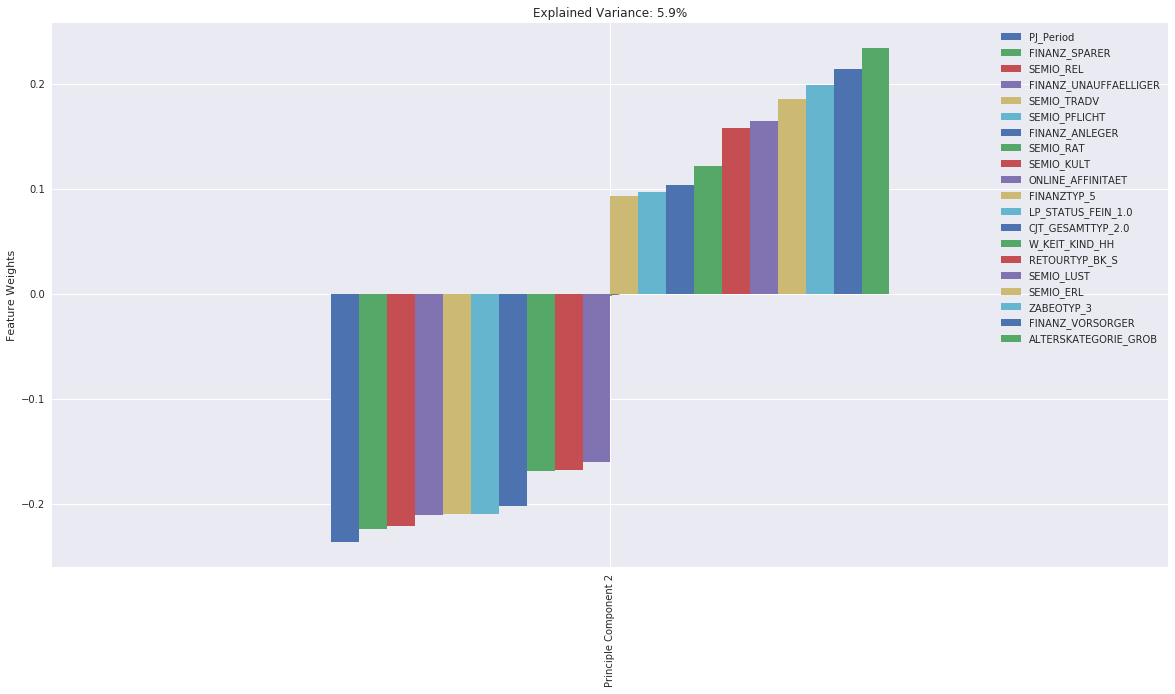

In [135]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp_2_results = pca_results(azidas_scaled_df, azidas_finalised, comp_num = 2)
comp_2_results

,ANREDE_KZ,SEMIO_KAEM,SEMIO_DOM,SEMIO_KRIT,SEMIO_ERL,FINANZ_ANLEGER,SEMIO_RAT,SHOPPER_TYP_2.0,FINANZTYP_1,LP_STATUS_FEIN_2.0,RETOURTYP_BK_S,ZABEOTYP_1,SEMIO_REL,SHOPPER_TYP_0.0,FINANZ_MINIMALIST,FINANZTYP_5,SEMIO_KULT,SEMIO_SOZ,SEMIO_FAM,SEMIO_VERT
Principle Component 3,-0.3426,-0.3122,-0.2793,-0.2604,-0.1996,-0.1549,-0.1547,-0.1021,-0.1001,-0.0831,0.0835,0.1189,0.1205,0.1242,0.1344,0.1366,0.2458,0.2553,0.2572,0.3205


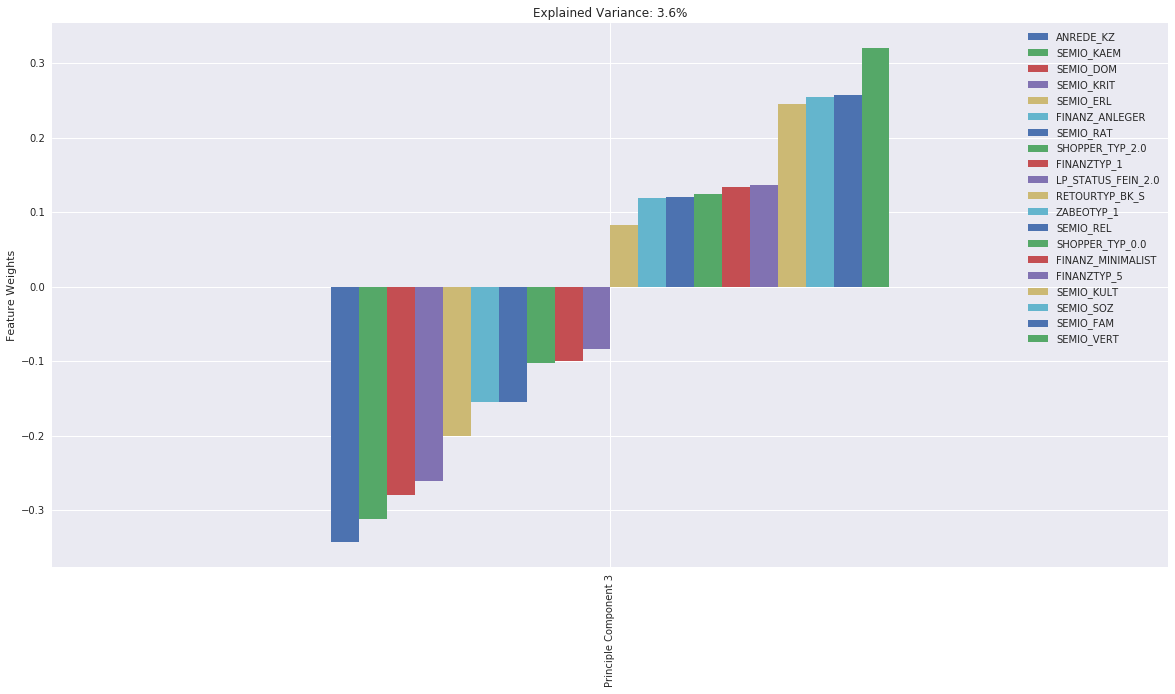

In [136]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp_3_results = pca_results(azidas_scaled_df, azidas_finalised, comp_num = 3)
comp_3_results

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

**Principal Component – 1**

Explained Variance: 8.2%

Top 3 Strongest **positive features**:
-	 LP_STATUS_GROB_1.0: (0.1918) Social status (rough scale); estimated household net income, 1.0 - low income earners
-	PLZ8_ANTG3: (0.1808) Number of 6-10 family houses in the PLZ8 region
-	HH_EINKOMMEN_SCORE: (0.1804) Estimated household net income

**_Interpretation_**

The positive features that influence PC1 the most are made up of income, social status and number of people within the family home. This appears to represent low income, densly populated areas. The relationship between low income earners and low social status would make sense in this case. As can be seen in both the developed and developing world, low income earners are often grouped together in state funded/supported house blocks that are densly populated.

Top 3 Strongest **negative features**:
-	MOBI_REGIO: (-0.2031) Movement patterns 
-	KBA05_ANTG1: (-0.1896) Number of 1-2 family houses in the microcell
-	FINANZ_MINIMALIST (-0.1864) low financial interest

**_Interpretation_**

Its slightly more difficult to describe the relationship between the strongest negative features and their positive counterparts, however the absolute value of their effective must be acknowledged. The negative features consist of movement patterns, sparse family houses in microcells and low financial interest. In contrast to the densly populated, low income positive features, the relations between the negative features may suggest more suburban commuter families, or retired persons attempting to escape city life.

**Principal Component – 2**

Explained Variance: 5.9%

Top 3 Strongest **positive features**:
-	ALTERSKATEGORIE_GROB: (0.2345) Estimated age based on given name analysis
-	FINANZ_VORSORGER: (0.2319) Financial typology, VORSORGER - be prepared
-	ZABEOTYP_3: (0.1995) Energy consumption typology fair supplied

**_Interpretation_**

The strongest positive features of the second principle component seem to capture age, attitude towards money and values when purchasing essentials. This could be interpreted as the relationship between different age groups are their financial viewpoint. Of course, given the period in which you were raised will subconsciously influence your tendency to save. i.e. if you were raised during a recession one would expect to save and be more frugal, regardless of the current economic climate the cautiousness will remain. Energy consumptionn fair supplied could suggest seeking for the best value, rather than paying a premium for "green" or efficient sources of energy or compromising on value for the cheapest option. Again, with climate change potentially more appealing and relevant to millenials, this could further explain the relationship between age, money and energy consumption.

Top 3 Strongest **negative features**:
-	P_J_Period: (-0.2358) Generation by decade 
-	FINANZ_SPARER: (-0.2238) Financial typology, SPARER - money-saver
-	SEMIO_REL: (-0.2204) Personality typology, REL - religious

**_Interpretation_**

The strongest negative features seem to capture interrelated characteristics as with the strongest features. Generation and religious tendencies are certainly dependent, particularly for older generations. This could also be coupled with the intent to save due to a lack of optimism in earlier generations during the rebuild of post war Germany.

**Principal Component – 3**

Explained Variance: 3.6%

Top 3 Strongest **positive features**:
-	SEMIO_VERT: (0.3205) Personality typology, VERT - dreamful 
-	SEMIO_FAM: (0.2572) Personality typology, FAM - family-minded
-	SEMIO_SOZ: (0.2553) Personality typology, SOZ - socially-minded

**_Interpretation_**

The positive features that most heavily influence the third principle component are all of the personality typology. Someone who is dreamful, family-minded and socially-minded could be described as someone with a lot of ambition to have a genuine social impact, create a sustainable fortune for their family and a prosperous career. This archetype may fit a young working professional or a young family. 

Top 3 Strongest **negative features**:
-	ANREDE_KZ: (-0.3426) Gender 
-	SEMIO_KAEM: (-0.3122) Personality typology, KAEM - combative attitude
-	SEMIO_DOM: (-0.2793) Personality typology, DOM - dominant-minded

**_Interpretation_**

The negative features that most heavily influence the third principle component are of the personality typology also and include gender. Someone who is combative and dominant minded speaks of resillience and determination but also potentially tempestuous and agressive which would suggest a hard upbringing or discrimination. This may explain why gender is related to these features as typically equal opportunities for women have been opressed until the most recent decades.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [137]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    #kmeans = KMeans(n_clusters=center)
    kmeans = MiniBatchKMeans(n_clusters=center, batch_size = 100000) #900,000 observations so consider larger batches vs time to compute

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score
    

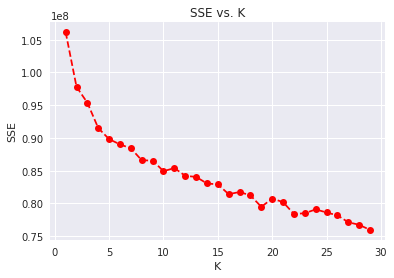

In [138]:
# Creating dataframe of PCA output for easier interpretation
comps_pca_final_df = pd.DataFrame(comps_finalised, \
                                      columns = [f"PC-{i}" for i in range(1,len(azidas_finalised.components_)+1)])
comps_pca_final_df.head()

# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Hold our model scores and initialise our centres
scores = []
centers = range(1,30)

# Iteratively run our Kmeans fitting function and append each centre score
for center in centers:
    scores.append(get_kmeans_score(comps_pca_final_df, center))

#Create our scree plot from the above output
plt.plot(centers, scores, linestyle='--', marker='o', color='r');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
 

In [139]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# From plot optimal centre looks to be somewhere between 5 and 15
optimal_centres = 9

kmeans_final = MiniBatchKMeans(optimal_centres, batch_size = 100000, random_state = 22)
kmeans_fit = kmeans_final.fit(comps_pca_final_df)

# Attaching predictions to dataframe
comps_pca_final_df["labels"] = kmeans_fit.labels_
comps_pca_final_df.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-77,PC-78,PC-79,PC-80,PC-81,PC-82,PC-83,PC-84,PC-85,labels
0,4.928407,-3.853590,-3.293266,1.034207,0.848211,0.963680,-1.663880,-0.394604,0.986689,3.051344,...,0.102762,1.457379,0.360723,-0.631540,-0.933022,-0.852053,1.794474,-2.784852,-1.702387,0
1,-0.484650,-0.680137,-3.398291,1.100597,-3.721608,-0.249981,-1.744614,-0.941673,-0.086473,-0.978961,...,-0.451230,-0.427615,-0.068146,-0.766775,-1.332560,-1.007085,0.035399,0.156182,-0.021975,2
2,-0.070664,0.282642,3.101131,0.897035,3.015479,-0.829213,-4.185051,-0.790270,-2.589769,-3.676776,...,0.067140,-0.130808,0.363839,-0.286070,-0.036719,-0.386808,-0.176287,-0.056639,-1.059352,8
3,-0.733343,-0.995296,-1.415196,-3.577436,-2.052985,-0.526238,-3.181857,-0.745162,0.830239,0.305731,...,-0.521916,-0.155322,-1.416689,1.129133,1.138042,0.007437,1.252784,-0.281235,-0.427603,2
4,1.096676,-4.128993,-3.315379,-1.211693,-1.924185,-1.799306,0.265702,-2.015578,0.519662,0.056503,...,-0.482366,0.439827,-0.463942,-0.521834,1.109311,0.043243,-0.270613,-0.133414,-0.024373,5


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

**Clustering Method Applied**

Due to the nature of this problem we have been instructed to apply KMeans clustering as an unsupervised technique. Originally I had set up to use the scikit learn’s KMeans class on the PCA-transformed data. Unfortunately this took a very long time to run so I decided to use a more computationally efficient adaptation of this class: MiniBatchKMeans. MinibatchKMeans is conducted on only a random sample of observations as opposed to all observations. This approach can significantly reduce the time required for the algorithm to find convergence (i.e. fit the data) with only a small cost in quality. MiniBatchKMeans works similarly to KMeans, with one significance difference: the batch_size parameter. batch_size controls the number of randomly selected observations in each batch. The larger the the size of the batch, the more computationally costly the training process. For the batch_size parameter I decided to take roughly 1/10th the size of the dataset or 100,000.

**Determining the “Elbow**

To Investigate the change in within-cluster distance I plotted the SSE iteratively over various number of centres. This allows us to visually understand when the reduction in SSE experiences diminishing marginal returns as we increase the number of centres in the KMeans fit.

**Final Number of Clusters**

As seen from the plot of K vs SSE, KMeans models with 0-5 centres show the largest decrease in SSE. From 5-10 the reduction in SSE levels off and from 10 centres onwards we see little valuable decrease in SSE for the additional complexity taken on by the Model. Given this observation I chose to take a value of 9 for K, although I would have been confident in choosing any value between 6 and 10 to achieve optimal results.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [140]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=";")

In [141]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Apply preprocessing
customers_cleaned = clean_data(azidas_scaled_df, customers, feat_info, 0.75)

# Apply feature scaling to the customer data.
customers_cleaned_scaled = scaler.transform(customers_cleaned)

# Apply PCA to the data.
customers_finalised, cust_comps_finalised = do_pca(85, customers_cleaned_scaled)

# Intepret principle components
#pca_results(customers_cleaned_scaled, customers_finalised, optimal_comps)

# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the customer data.
# Creating dataframe of PCA output for easier interpretation
cust_comps_pca_final_df = pd.DataFrame(cust_comps_finalised, \
                                      columns = [f"PC-{i}" for i in range(1,len(customers_finalised.components_)+1)])
customer_preds = kmeans_final.predict(cust_comps_pca_final_df)

No. of rows containing any NaNs:0
Total no. of NaNs: 0
No. of rows remaining:144491
No. of cols remaining:195


In [142]:
# Check cleaning results before proceeding

customers_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PJ_Period,PJ_Movement,CI15_Wealth,CI15_LS,WOHNLAGE_NBH,PLZ8_BAUMAX_HOMES,PLZ8_BAUMAX_BUSINESS,GEBAEUDETYP_5.0
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,2.0,0.0,1.0,3.0,0.0,1.0,0.0,0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,2.0,0.0,3.0,4.0,2.0,3.0,0.0,0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,1.0,1.0,2.0,4.0,0.0,1.0,0.0,0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,4.0,1.0,4.0,1.0,3.0,2.0,0.0,0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,2.0,0.0,3.0,4.0,1.0,1.0,0.0,0


In [143]:
# Check scaling results before proceeding

customers_cleaned_scaled_df = pd.DataFrame(customers_cleaned_scaled, columns = customers_cleaned.columns,\
                                                index = customers_cleaned.index)
customers_cleaned_scaled_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PJ_Period,PJ_Movement,CI15_Wealth,CI15_LS,WOHNLAGE_NBH,PLZ8_BAUMAX_HOMES,PLZ8_BAUMAX_BUSINESS,GEBAEUDETYP_5.0
0,1.164063,-1.025197,1.411386,-1.132765,1.113406,-1.236113,-0.407255,-0.834925,1.841624,-1.610388,...,-0.17991,-0.193076,23.863702,-2.843469,0.558311,-0.095249,-1.914861,-0.867500,-1.290909,-0.378929
2,1.164063,0.975423,1.411386,-1.132765,1.113406,-1.236113,1.048651,0.615786,1.841624,-0.285764,...,-0.17991,-0.193076,23.863702,-2.843469,5.257166,0.573619,-0.580972,0.361178,-1.290909,-0.378929
3,1.164063,-1.025197,1.411386,-1.132765,1.113406,-0.548762,-1.135207,-0.834925,-0.542999,-0.285764,...,-0.17991,-0.193076,11.889798,-2.178855,2.907739,0.573619,-1.914861,-0.867500,-1.290909,-0.378929
4,0.193497,-1.025197,-0.056134,-1.132765,0.392200,0.825941,1.776603,-0.834925,-0.542999,1.038860,...,-0.17991,-0.193076,47.811510,-2.178855,7.606594,-1.432984,0.085973,-0.253161,-1.290909,-0.378929
5,0.193497,-1.025197,1.411386,-1.132765,1.113406,-1.236113,-0.407255,-0.109569,1.841624,1.038860,...,-0.17991,-0.193076,23.863702,-2.843469,5.257166,0.573619,-1.247917,-0.867500,-1.290909,-0.378929


In [144]:
# Check PCA results before proceeding

cust_comps_pca_final_df.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-76,PC-77,PC-78,PC-79,PC-80,PC-81,PC-82,PC-83,PC-84,PC-85
0,-20.211383,-0.576756,-3.833362,-12.138761,-4.313125,-0.848692,0.361307,-0.885159,-0.526987,-0.611043,...,-0.465526,1.307649,-0.580925,0.560397,0.487676,0.152385,0.759129,0.604496,0.195175,0.413142
1,-20.543114,-1.260457,42.533063,1.605159,0.817688,-0.546433,-2.121136,-1.317633,-0.348141,2.410208,...,-0.103679,-0.263813,0.148120,0.197431,-0.079952,0.363192,0.475170,0.301591,-0.146498,-0.075090
2,-20.198859,-0.383437,-0.579214,-23.345693,-2.722943,-4.809178,-0.862308,5.254531,5.430249,-3.160167,...,-0.180911,0.526434,0.178942,-0.373919,-0.071731,-0.002607,0.281756,-0.248195,-0.432585,0.149057
3,-20.328651,-0.934154,-10.430559,11.405064,4.797206,0.353857,-0.646848,-0.143212,-0.165719,-2.099253,...,-1.570507,0.203674,-1.259049,-1.012601,-1.011348,3.927732,-3.205614,1.035834,-1.963490,0.179331
4,-20.278709,-0.595325,-3.611892,-11.842296,0.820307,8.553283,1.876911,1.553813,-0.139195,-1.080437,...,-0.286553,-0.133985,1.227684,-0.489126,-0.606632,0.603434,0.203524,-0.722902,1.381679,-1.484000


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [145]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Using total number of entries in each dataset
# to normalise cluster proportions
azdias_total_entries = azdias.shape[0]
cust_total_entries = customers.shape[0]

# Percentage of population clusters
population_label_counts  = list(comps_pca_final_df["labels"].value_counts()/azdias_total_entries*100)

# Population cluster No.
# Adjusted by +0.8 so as to start numbering 
# at 1 then move population bars to the left
pop_labels = list(comps_pca_final_df["labels"].value_counts().index+0.85)


# Grouping labels and counts for customers
customer_labels_dict = Counter(customer_preds)
customer_labels = list(customer_labels_dict.keys())
# Adding 1.15 to start clusters (labels) at 1 and
# to adjusting bar position on plot 
customer_labels_adj = [i + 1.15 for i in customer_labels]

# Percentage of population clusters
customer_label_counts = list(customer_labels_dict.values())
cust_label_perc = [(j/cust_total_entries*100) for j in customer_label_counts]

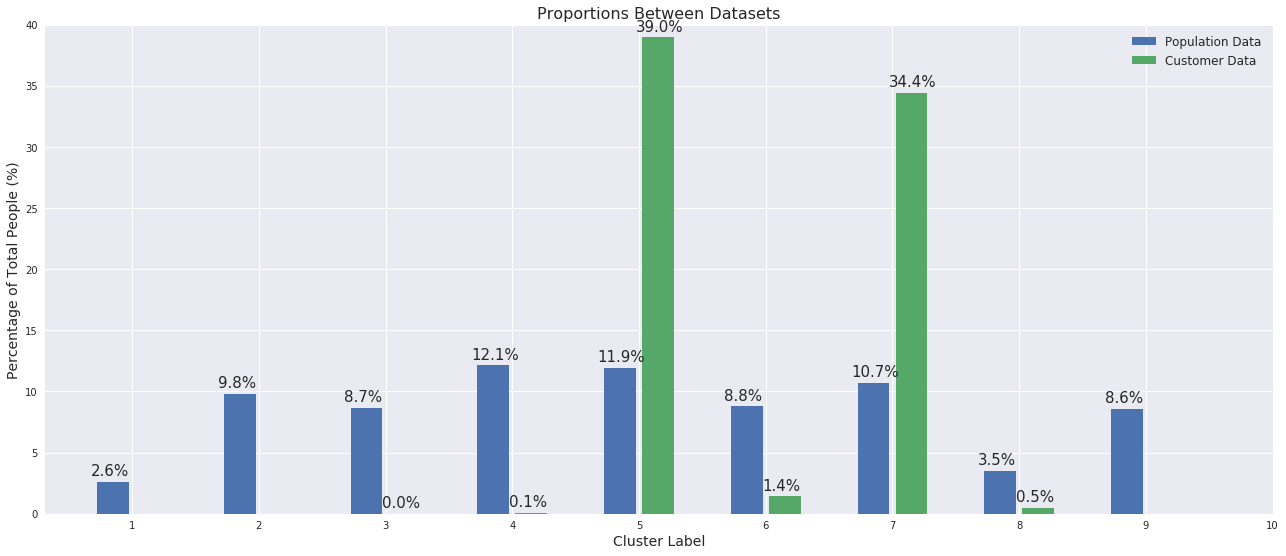

In [153]:
# Plotting clusters for population and customer datasets
fig, ax = plt.subplots(figsize = (22,9))

ax.bar(pop_labels,population_label_counts,width = 0.25,label='Population Data', zorder=3)
ax.bar(customer_labels_adj,cust_label_perc, width = 0.25, label='Customer Data', zorder=3)


ax.yaxis.grid(zorder=0)
ax.set_ylim(0,40)
ax.set_ylabel('Percentage of Total People (%)', fontsize = 14)

ax.xaxis.set(ticks=range(1,11))
ax.set_xlabel('Cluster Label', fontsize = 14)

plt.title('Proportions Between Datasets', fontsize = 16)
plt.legend(loc='best', fontsize=12)

# Collecting percentage data
component_perct_lab = []
for i in ax.patches:
    component_perct_lab.append(i.get_height())

for i,j in zip(ax.patches,component_perct_lab):
    ax.text(i.get_x()-.05, j+.5, str(round((j), 1))+'%', fontsize=15)

    
plt.show()


In [154]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Obtaining cluster centroids and related PC strengths
centroids_pcs = kmeans_final.cluster_centers_

centroids_pcs_df = pd.DataFrame(centroids_pcs, columns = cust_comps_pca_final_df.columns)

# Cluster 5 is over-represented as seen from bar plot
# Finding strongly associated PCs for this cluster:
centroids_pcs_df.loc[3:4,:].sort_values(by = 4,axis=1, ascending = False).head(n=3)

,PC-7,PC-5,PC-19,PC-11,PC-20,PC-13,PC-33,PC-24,PC-32,PC-21,...,PC-16,PC-14,PC-9,PC-26,PC-2,PC-17,PC-23,PC-15,PC-4,PC-1
3,0.588605,0.667121,0.117954,-0.468172,0.058995,-0.057321,-0.070900,-0.135015,-0.088171,-0.066844,...,0.011782,-0.201996,0.327325,0.340881,4.006236,0.099105,0.094945,0.027590,0.027862,3.544132
4,1.372563,1.225445,0.700018,0.571395,0.219956,0.214115,0.213136,0.184294,0.134188,0.119712,...,-0.210290,-0.243885,-0.315917,-0.337977,-0.417747,-0.421570,-0.473469,-0.838283,-2.130497,-4.170518


,SEMIO_KRIT,CAMEO_DEU_2015_8A,SEMIO_KAEM,ANREDE_KZ,FINANZ_HAUSBAUER,HH_EINKOMMEN_SCORE,SEMIO_ERL,CAMEO_DEU_2015_3C,ZABEOTYP_3,ANZ_HAUSHALTE_AKTIV,GREEN_AVANTGARDE,CAMEO_DEU_2015_1D,LP_STATUS_GROB_3.0,ANZ_PERSONEN,ZABEOTYP_1,ANZ_TITEL,CI15_Wealth,LP_STATUS_FEIN_7.0,CAMEO_DEUG_2015_6,CAMEO_DEU_2015_6B
Principle Component 7,-0.111,-0.11,-0.1049,-0.1046,-0.0933,-0.0922,-0.0887,-0.0788,-0.077,-0.072,0.0961,0.1006,0.1024,0.1042,0.1212,0.1313,0.1752,0.1794,0.2726,0.719


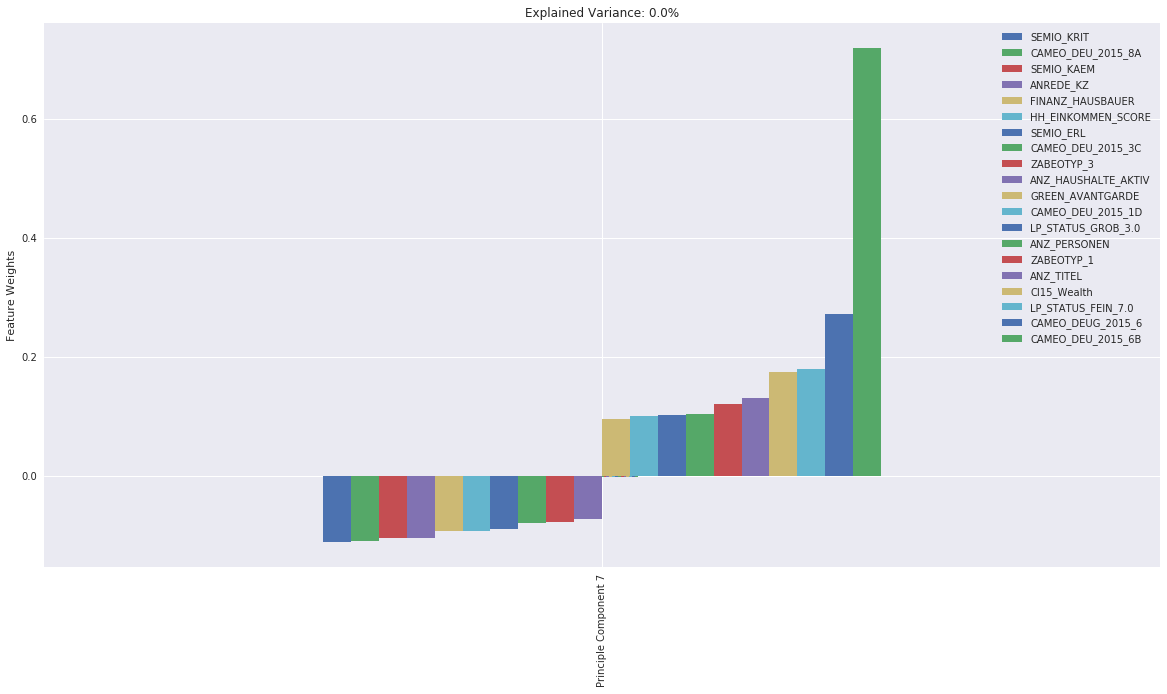

In [155]:
# 7th principal component has the strongest association with the 5th cluster.

pca_results(customers_cleaned_scaled_df, customers_finalised, 7)

In [165]:
# Strongest negative Features

#Personality typology, for each dimension:
#- -1: unknown
#-  1: highest affinity
#-  2: very high affinity
#-  3: high affinity
#-  4: average affinity
#-  5: low affinity
#-  6: very low affinity
#-  7: lowest affinity
#-  9: unknown

#Dimension translations:
#- SOZ: socially-minded
#- FAM: family-minded
#- REL: religious
#- MAT: materialistic
#- VERT: dreamful
#- LUST: sensual-minded
#- ERL: event-oriented
#- KULT: cultural-minded
#- RAT: rational
#- KRIT: critical-minded
#- DOM: dominant-minded
#- KAEM: combative attitude
#- PFLICHT: dutiful
#- TRADV: tradional-minded

print(f"Customer represntation mean of personality topology - critical-minded:{ customers_cleaned['SEMIO_KRIT'].mean() }")
print(f"Population represntation mean of personality topology - critical-minded:{ azdias_cleaned['SEMIO_KRIT'].mean() }")

Customer represntation mean of personality topology - critical-minded:3.923939899370895
Population represntation mean of personality topology - critical-minded:4.496170938872348


In [163]:
# Strongest Positive Features

### 4.2. CAMEO_DEU_2015
# German CAMEO: Wealth / Life Stage Typology, detailed scale
# - 1A: Work-Life-Balance
# - 1B: Wealthy Best Ager
# - 1C: Successful Songwriter
# - 1D: Old Nobility
# - 1E: City Nobility
# - 2A: Cottage Chic
# - 2B: Noble Jogger
# - 2C: Established gourmet
# - 2D: Fine Management
# - 3A: Career & Family
# - 3B: Powershopping Families
# - 3C: Rural Neighborhood
# - 3D: Secure Retirement
# - 4A: Family Starter
# - 4B: Family Life
# - 4C: String Trimmer
# - 4D: Empty Nest
# - 4E: Golden Ager
# - 5A: Younger Employees
# - 5B: Suddenly Family
# - 5C: Family First
# - 5D: Stock Market Junkies
# - 5E: Coffee Rider
# - 5F: Active Retirement
# - 6A: Jobstarter
# - 6B: Petty Bourgeois
# - 6C: Long-established
# - 6D: Sportgardener
# - 6E: Urban Parents
# - 6F: Frugal Aging
# - 7A: Journeymen
# - 7B: Mantaplatte
# - 7C: Factory Worker
# - 7D: Rear Window
# - 7E: Interested Retirees
# - 8A: Multi-culteral
# - 8B: Young & Mobile
# - 8C: Prefab
# - 8D: Town Seniors
# - 9A: First Shared Apartment
# - 9B: Temporary Workers
# - 9C: Afternoon Talk Show
# - 9D: Mini-Jobber
# - 9E: Socking Away
# - XX: unknown

print(f"Customer represntation mean of wealth topology - Petty Bourgeois:{ customers_cleaned['CAMEO_DEU_2015_6B'].mean() }")
print(f"Population represntation mean of wealth topology - Petty Bourgeois:{ azdias_cleaned['CAMEO_DEU_2015_6B'].mean() }")

Customer represntation mean of wealth topology - Petty Bourgeois:0.06667543307195604
Population represntation mean of wealth topology - Petty Bourgeois:0.07235917499145364


In [171]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 6 is under-represented as seen from bar plot
# Finding strongly associated PCs for this cluster:
centroids_pcs_df.loc[5:6].sort_values(by = 5, axis=1, ascending = False).head(n=1)

,PC-1,PC-4,PC-11,PC-20,PC-9,PC-24,PC-29,PC-23,PC-19,PC-35,...,PC-27,PC-31,PC-40,PC-18,PC-12,PC-26,PC-5,PC-6,PC-2,PC-3
5,4.320318,0.747648,0.691327,0.507282,0.456965,0.42762,0.276186,0.241259,0.140574,0.09387,...,-0.200334,-0.20448,-0.224537,-0.231698,-0.293896,-0.301104,-0.318437,-0.392123,-2.539614,-2.711898


,MIN_GEBAEUDEJAHR,GEBAEUDETYP_8.0,CI15_Wealth,GEBAEUDETYP_RASTER,PJ_Period,PLZ8_HHZ,PLZ8_GBZ,PLZ8_ANTG2,ARBEIT,KBA05_GBZ,PJ_Movement,FINANZ_ANLEGER,SHOPPER_TYP_3.0,SEMIO_PFLICHT,ZABEOTYP_6,ZABEOTYP_3,FINANZ_UNAUFFAELLIGER,SEMIO_MAT,FINANZTYP_3,FINANZTYP_2
Principle Component 1,-0.9999,-0.0064,-0.0053,-0.0038,-0.0034,-0.0033,-0.0029,-0.0026,-0.0025,-0.0024,0.0003,0.0004,0.0004,0.0005,0.0005,0.0006,0.0007,0.0007,0.0008,0.0011


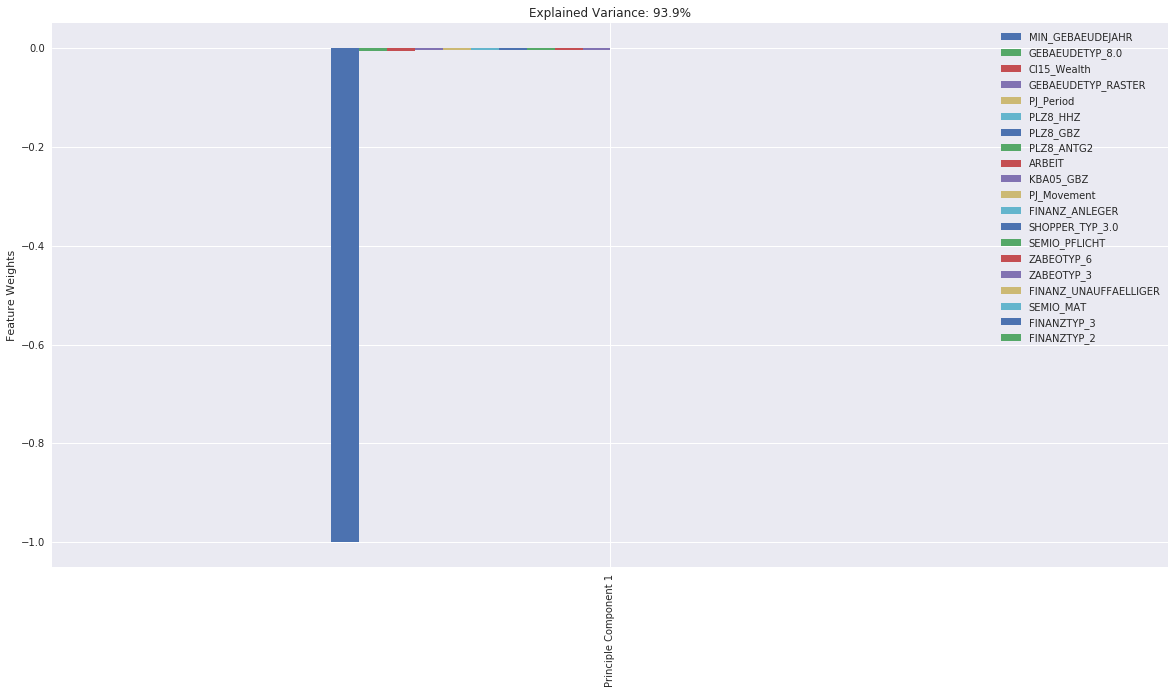

In [167]:
# 1st principal component has the strongest association with the 6th cluster.

# Investgating related features to Nth principal component ("PC-")
pca_results(customers_cleaned_scaled_df, customers_finalised, 1)

In [168]:
# Strongest Negative feature

#First year building was mentioned in the database

# Calculating mean financial topology

print(f"Customer represntation mean of First year building was mentioned in the database:{ customers_cleaned['MIN_GEBAEUDEJAHR'].mean() }")
print(f"Population represntation mean of First year building was mentioned in the database:{ azdias_cleaned['MIN_GEBAEUDEJAHR'].mean() }")

Customer represntation mean of First year building was mentioned in the database:1954.9034541943788
Population represntation mean of First year building was mentioned in the database:1992.7177992175334


In [169]:
# Strongest Positive feature

### 1.6. FINANZTYP
# Most descriptive financial type for individual
# - -1: unknown
# -  1: low financial interest (MINIMALIST)
# -  2: money-saver (SPARER)
# -  3: home ownership (HAUSBAUER)
# -  4: be prepared (VORSORGER)
# -  5: investor (ANLEGER)
# -  6: inconspicuous (UNAUFFAELLIGER)

# Calculating mean period of person's youth

print(f"Customer represntation mean of Most descriptive financial type for individual - money-saver:{ customers_cleaned['FINANZTYP_2'].mean() }")
print(f"Population represntation mean of Most descriptive financial type for individual - money-saver:{ azdias_cleaned['FINANZTYP_2'].mean() }")

Customer represntation mean of Most descriptive financial type for individual - money-saver:0.304018935435425
Population represntation mean of Most descriptive financial type for individual - money-saver:0.13138749046752238


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

**Methodology**
The clustering analysis shows that there is indeed disparities in the representation of the general population and the customer data. In order to get a better feel for what this disparity actually looked like in the form of features, each of the cluster centroids were mapped back to their corresponding PCs and ranked in order of importance. From here we can extract the strongest absolute features and compare their means to provide a better indication as to why the gaps in the two groups exist.


**Popular segments**
From the barchart it is clear to see that cluster 5 and cluster 7 are quite popular segments compared with the general population. I decided to profile cluster 5 further to investigate why this might be the case. PC7 had the highest positive weight for this cluster so I chose this PC and extracted its feature composition. The two most influential features are as follows:
- SEMIO_KRIT - personality topology - critical-minded
- CAMEO_DEU_2015_6B - wealth topology - Petty Bourgeois

For SEMIO_KRIT we can see that there is a difference in means between the customer data and the population data:

Customer represntation mean of personality topology - critical-minded:3.923939899370895
Population representation mean of personality topology - critical-minded:4.496170938872348

This shows that customers within this cluster have a higher affinity with being critical minded than the general population. Critical mindedness is generally perceived as being analytical and open to numerous viewpoints. Perhaps these customers are more open to purchasing goods via mail order due to its convenience and are not sceptical of potential damage to goods or delayed delivery.

As for CAMEO_DEU_2015_6B the difference in means is as follows:

Customer represntation mean of wealth topology - Petty Bourgeois:0.06667543307195604
Population represntation mean of wealth topology - Petty Bourgeois:0.07235917499145364

Petty Bourgeois is synonymous in socialism to the middle-class. As this variable was reconstrcuted using one hot encoding we can then understand from the comparison of means that the customers in this cluster are slightly less like the middle class than the rest of the general population indicating that existing customers may be in the lower income earner bracket.

**Unpopular segments**

From the barchart it is clear to see that clusters 1-4,6,8 and 9 are quite unpopular segments compared with the existing customer base. I decided to profile cluster 6 further to investigate why this might be the case. PC1 had the highest positive weight for this cluster so I chose this PC and extracted its feature composition. The two most influential features are as follows:
- MIN_GEBAEUDEJAHR - First year building was mentioned in the database
- FINANZTYP_2 - Most descriptive financial type for individual - money-saver

For MIN_GEBAEUDEJAHR we can see that there is a difference in means between the customer data and the population data:

Customer represntation mean of First year building was mentioned in the database:1954.9034541943788
Population represntation mean of First year building was mentioned in the database:1992.7177992175334

This shows that the general population are recorded as having much more recent homes than the existing customer base. This may be down to how and when the data has been collected and if new areas have been targeted over time as a data acquistion exercise. On the other hand however, it could suggest one of two things, the general population are living in newer developments, either privately owned or state owned. Secondly, one might expect that older demographics are more likely to occupy and hold onto older family homes through generations. This may indicate that the existing customer base represented by this cluster is of an older age group. To be ceratin though, more information is required regarding the potential data collection biases.

As for FINANZTYP_2 the difference in means is as follows:

Customer represntation mean of Most descriptive financial type for individual - money-saver:0.304018935435425
Population represntation mean of Most descriptive financial type for individual - money-saver:0.13138749046752238

As this variable was reconstrcuted using one hot encoding we can then understand from the comparison of means that the general population in this cluster are less likely to be money savers than the customers in this cluster. This could potentially open avenues for new business models and services as if it was necessary to try and attract the general population of this segment then a premium or express service may be suitable. Furthermore, as the population seem to be less inclined to save money than the existing customers this could potentially mean that they have more disposable income to spend on such a service.

### Resources used throughout the project:

- https://scikit-learn.org/stable/modules/clustering.html
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans
- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py
- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
- https://scikit-learn.org/0.18/auto_examples/cluster/plot_cluster_comparison.html
- https://scikit-learn.org/stable/tutorial/statistical_inference/unsupervised_learning.html
- https://www.datacamp.com/community/tutorials/k-means-clustering-python
- https://www.naftaliharris.com/blog/visualizing-k-means-clustering/
- https://mubaris.com/posts/kmeans-clustering/
- https://medium.com/@rrfd/cleaning-and-prepping-data-with-python-for-data-science-best-practices-and-helpful-packages-af1edfbe2a3
- https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj
- https://www.datacamp.com/community/tutorials/categorical-data
- https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html
- https://chrisalbon.com/machine_learning/clustering/minibatch_k-means_clustering/
- https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21
- https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.